# Problem Definition

# Our dataset belongs to a digital streaming platform for movies and TV series. It consists of 21 variables and approximately 245,000 observations. The aim of this problem is to predict customers who will "churn" in advance and assist relevant departments by providing the information of these individuals for preparing necessary action plans

Columns :

CustomerID: Unique identifier for each customer

SubscriptionType: Type of subscription plan chosen by the customer (e.g., Basic, Premium, Deluxe)

PaymentMethod: Method used for payment (e.g., Credit Card, Electronic Check, PayPal)

PaperlessBilling: Whether the customer uses paperless billing (Yes/No)

ContentType: Type of content accessed by the customer (e.g., Movies, TV Shows, Documentaries)

MultiDeviceAccess: Whether the customer has access on multiple devices (Yes/No)

DeviceRegistered: Device registered by the customer (e.g., Smartphone, Smart TV, Laptop)

GenrePreference: Genre preference of the customer (e.g., Action, Drama, Comedy)

Gender: Gender of the customer (Male/Female)

ParentalControl: Whether parental control is enabled (Yes/No)

SubtitlesEnabled: Whether subtitles are enabled (Yes/No)

AccountAge: Age of the customer's subscription account (in months)

MonthlyCharges: Monthly subscription charges

TotalCharges: Total charges incurred by the customer

ViewingHoursPerWeek: Average number of viewing hours per week

SupportTicketsPerMonth: Number of customer support tickets raised per month

AverageViewingDuration: Average duration of each viewing session

ContentDownloadsPerMonth: Number of content downloads per month

UserRating: Customer satisfaction rating (1 to 5)

WatchlistSize: Size of the customer's content watchlist

Churn: Situation of customer churn or not (target variable)

In [2]:
# Importing the Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import datetime as dt
import warnings
import math
import random
import itertools

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import BalancedBaggingClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

In [3]:
# Making the Necessary Adjustments
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=Warning)

In [19]:
# Readin Data
df_ = pd.read_csv("/kaggle/input/predictive-analytics-for-customer-churn-dataset/train.csv")
df = df_.copy()
df.head()

AccountAge  MonthlyCharges  TotalCharges SubscriptionType     PaymentMethod PaperlessBilling ContentType MultiDeviceAccess DeviceRegistered  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth GenrePreference  UserRating  SupportTicketsPerMonth  Gender  WatchlistSize ParentalControl SubtitlesEnabled  CustomerID  Churn
0          20       11.055215    221.104302          Premium      Mailed check               No        Both                No           Mobile            36.758104               63.531377                        10          Sci-Fi    2.176498                       4    Male              3              No               No  CB6SXPNVZA      0
1          57        5.175208    294.986882            Basic       Credit card              Yes      Movies                No           Tablet            32.450568               25.725595                        18          Action    3.478632                       8    Male             23              No              Yes  S7R2G87O09      0
2          73       12.106657    883.785952            Basic      Mailed check              Yes      Movies                No         Computer             7.395160               57.364061                        23         Fantasy    4.238824                       6    Male              1             Yes              Yes  EASDC20BDT      0
3          32        7.263743    232.439774            Basic  Electronic check               No    TV Shows                No           Tablet            27.960389              131.537507                        30           Drama    4.276013                       2    Male             24             Yes              Yes  NPF69NT69N      0
4          57       16.953078    966.325422          Premium  Electronic check              Yes    TV Shows                No               TV            20.083397               45.356653                        20          Comedy    3.616170                       4  Female              0              No               No  4LGYPK7VOL      0

In [20]:
# Analysis of Data Set
def show_info(dataframe):
    print("***** NAN *****")
    print(dataframe.isnull().sum())
    print("***** Duplicated *****")
    print(dataframe.duplicated().sum())
    print("***** NUNIQUE *****")
    print(dataframe.nunique())
    print("***** INFO *****")
    print(dataframe.info())
    print("***** COLUMNS *****")
    print(dataframe.columns)
    print("***** DESCRIPTIVE STATISTICS *****")
    print(dataframe.describe().T)

print(show_info(df))

***** NAN *****
AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
Churn                       0
dtype: int64
***** Duplicated *****
0
***** NUNIQUE *****
AccountAge                     119
MonthlyCharges              243787
TotalCharges                243787
SubscriptionType                 3
PaymentMethod                    4
PaperlessBilling                 2
ContentType                      3
MultiDeviceAccess                2
DeviceRegistered

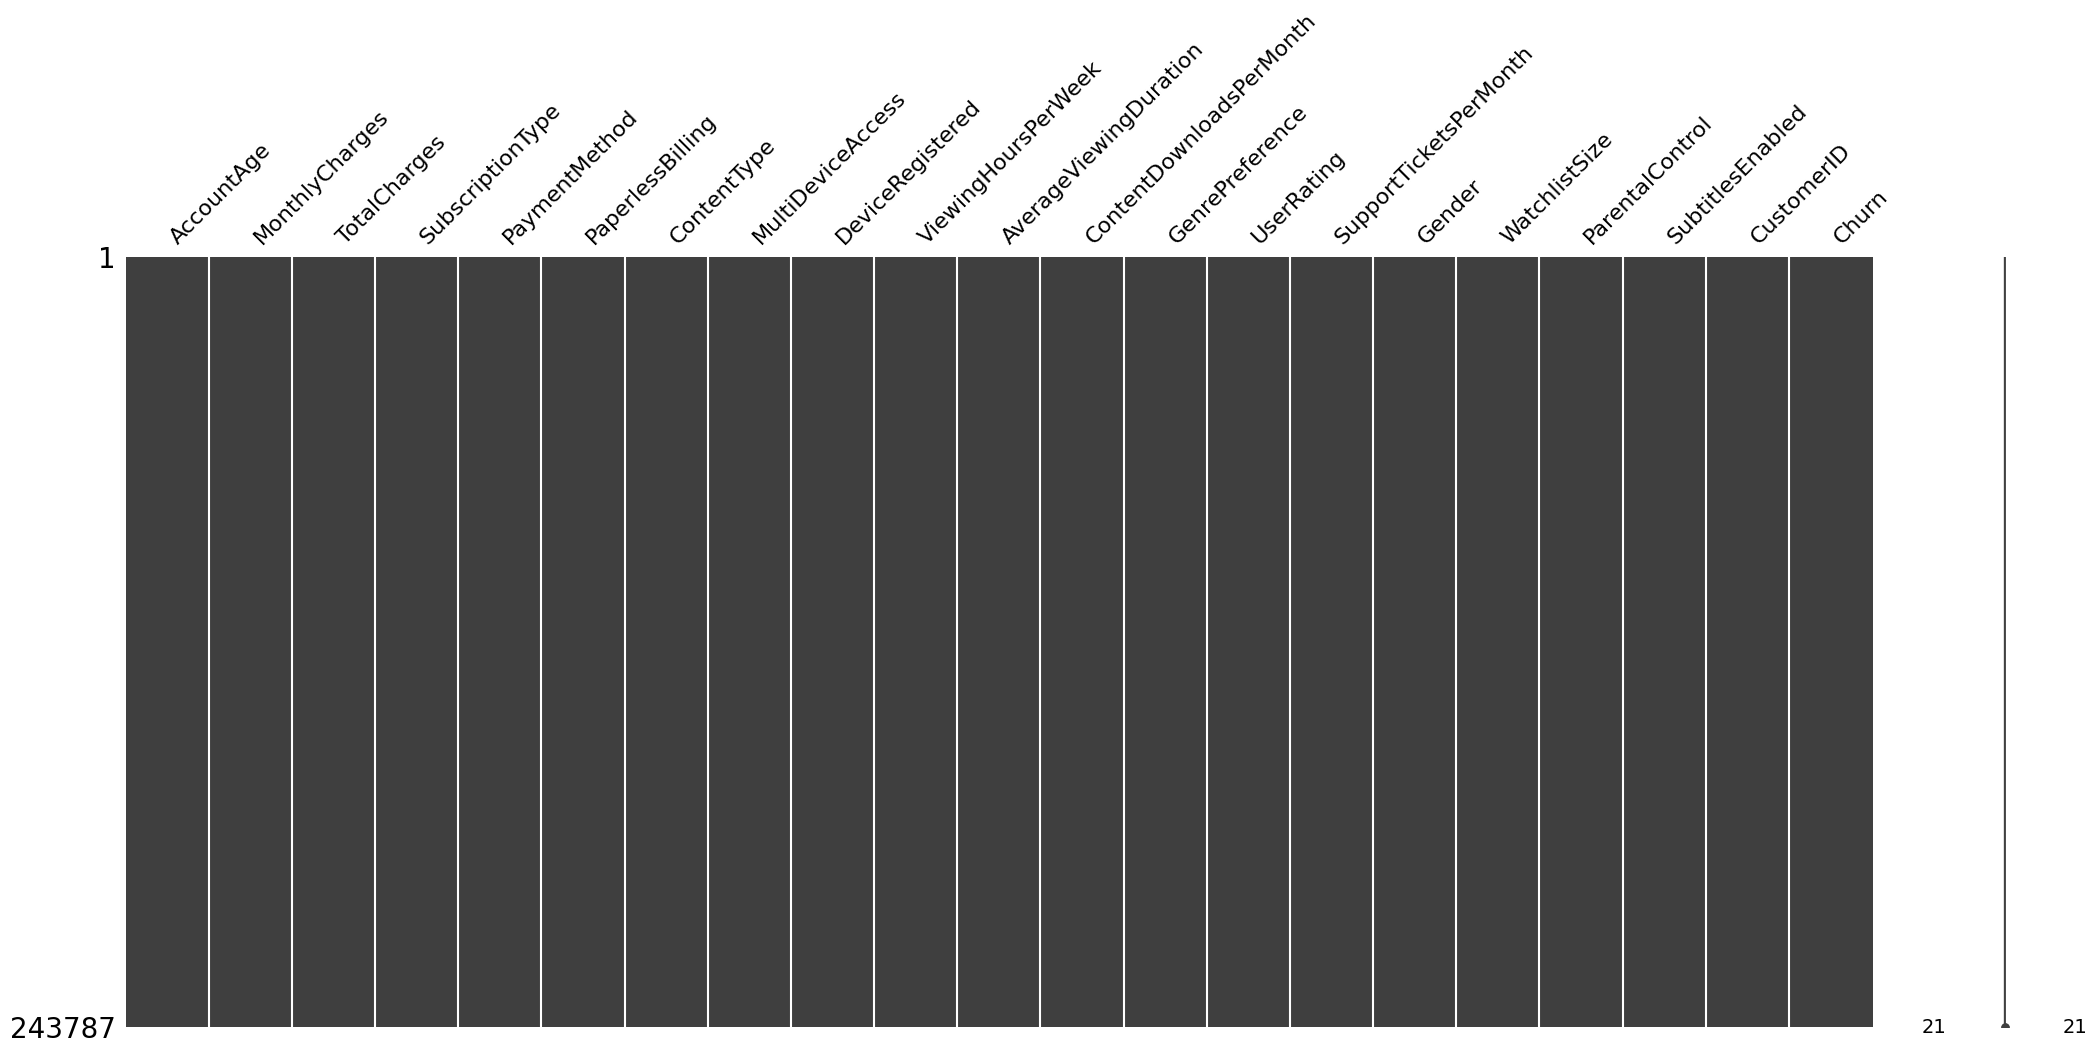

In [21]:
# Analysis of Missing Number 
import missingno as msn
msn.matrix(df)
plt.show()

In [22]:
# Grab Variables
def grab_variable(dataframe, num_th=10, car_th=20, var_name=False):
    
    # Categoric Variables #
    
    cat_var = [i for i in dataframe.columns if dataframe[i].dtypes in ["object", "category", "bool"]]
    
    num_but_cat = [i for i in dataframe.columns if dataframe[i].dtypes in ["int64", "float64"]
                   and dataframe[i].nunique() <= num_th]
    
    cat_but_car = [i for i in dataframe.columns if dataframe[i].dtypes in ["category", "object"]
                   and dataframe[i].nunique() > car_th]
    
    cat_var = cat_var + num_but_cat
    cat_var = [i for i in cat_var if i not in cat_but_car]

    # Numeric Variables #
    num_var = [i for i in dataframe.columns if dataframe[i].dtypes in ["int64", "float64"]
               and dataframe[i].nunique() > num_th]

    print("Observation:", len(dataframe))
    print("Number of Variables:", len(dataframe.columns))
    print("Number of Categoric Variables:", len(cat_var))
    print("Number of Num but Cat Variables:", len(num_but_cat))
    print("Number of Cat but Cardinal Variables:", len(cat_but_car))
    print("Number of Numeric Variables:", len(num_var))

    if var_name:
        print("Categoric Variables:", cat_var)
        print("Numeric But Categoric Variables:", num_but_cat)
        print("Categoric But Cardinal Variables:", cat_but_car)
        print("Numeric Variables:", num_var)
    return cat_var, cat_but_car, num_var

cat_var, cat_but_car, num_var = grab_variable(df)

Observation: 243787
Number of Variables: 21
Number of Categoric Variables: 12
Number of Num but Cat Variables: 2
Number of Cat but Cardinal Variables: 1
Number of Numeric Variables: 8


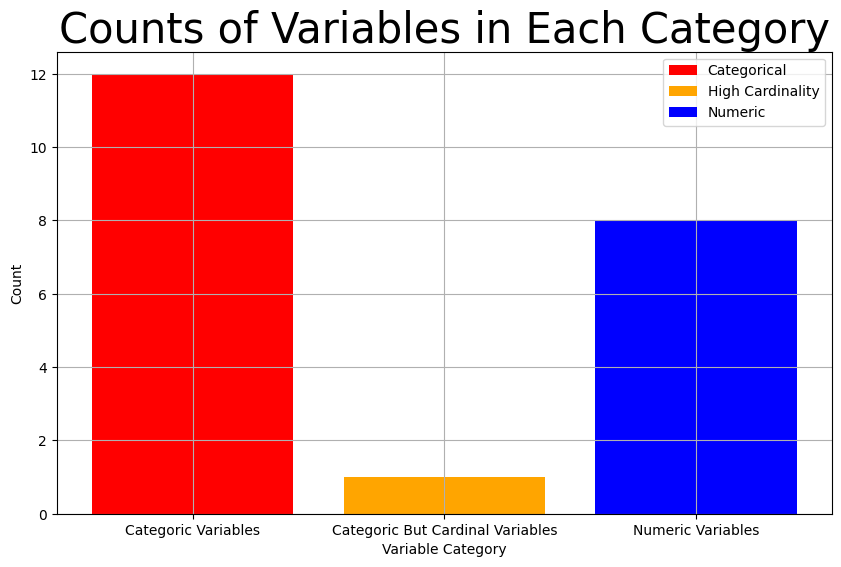

In [23]:
def plot_variable_counts(cat_var, cat_but_car, num_var):
    # Count the number of variables in each category
    category_counts = [len(cat_var), len(cat_but_car), len(num_var)]
    categories = ['Categoric Variables', 'Categoric But Cardinal Variables', 'Numeric Variables']

    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, category_counts, color=['red', 'orange', 'blue'])
    plt.title('Counts of Variables in Each Category', fontsize=30)
    plt.xlabel('Variable Category')
    plt.ylabel('Count')
    plt.grid()
    legend_labels = ['Categorical', 'High Cardinality', 'Numeric']
    plt.legend(bars, legend_labels, loc="upper right")
    plt.show()

plot_variable_counts(cat_var, cat_but_car, num_var)

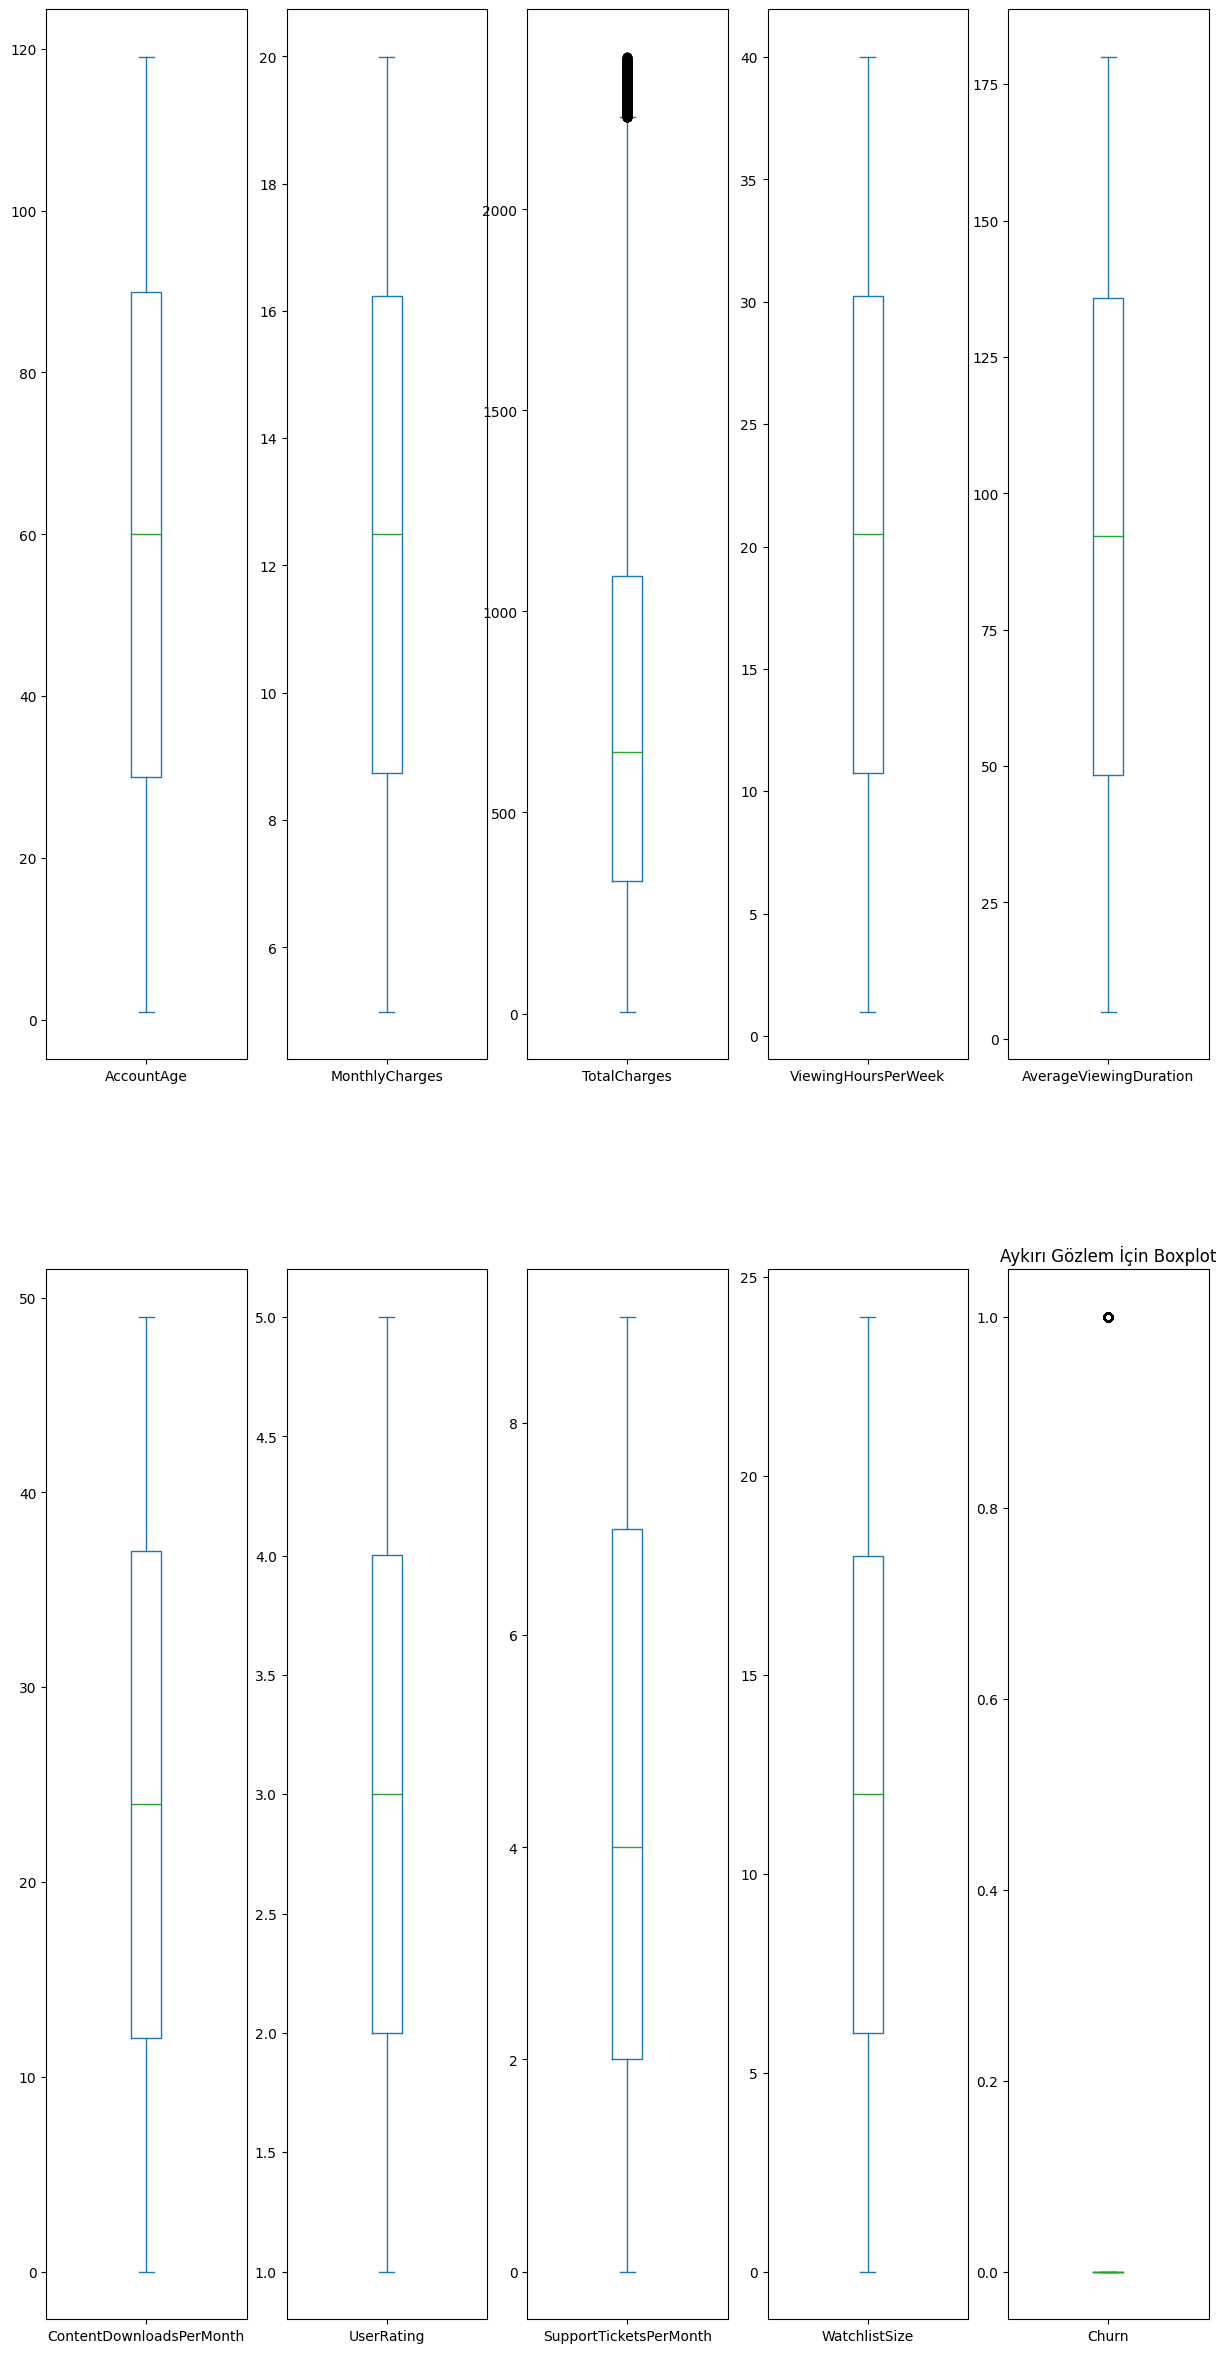

In [24]:
# Analysis of Oultiers
df.plot(kind="box", subplots=True, figsize=(15, 30), layout=(2, 5))
plt.title("Aykırı Gözlem İçin Boxplot")
plt.show()

In [25]:
# Finding Thresholds (Limits)
def outlier_thresholds(dataframe, variable, q1=0.25, q3=0.75):
    q1 = dataframe[variable].quantile(q1)
    q3 = dataframe[variable].quantile(q3)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    return lower_limit, upper_limit

for i in num_var:
    print(i, ":", outlier_thresholds(df, i))

AccountAge : (-60.0, 180.0)
MonthlyCharges : (-2.5108822537315287, 27.487585566502734)
TotalCharges : (-811.1084761822483, 2229.5728643148022)
ViewingHoursPerWeek : (-18.419212297484723, 59.40256110709355)
AverageViewingDuration : (-82.90608528289064, 267.1965276075546)
ContentDownloadsPerMonth : (-25.5, 74.5)
UserRating : (-1.0011033867446884, 7.004113639054296)
WatchlistSize : (-12.0, 36.0)


In [26]:
def check_outlier(dataframe, variable):
    lower_limit, upper_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < lower_limit) | (dataframe[variable] > upper_limit)].shape[0] > 0:
        print(variable, "-->", len(dataframe[(dataframe[variable] < lower_limit) | (dataframe[variable] > upper_limit)]))
        return True
    else:
        return False
        
for i in num_var:
    print(i, ":", check_outlier(df, i))

AccountAge : False
MonthlyCharges : False
TotalCharges --> 741
TotalCharges : True
ViewingHoursPerWeek : False
AverageViewingDuration : False
ContentDownloadsPerMonth : False
UserRating : False
WatchlistSize : False


In [27]:
def suppress_outliers(dataframe, variable):
    lower_limit, upper_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[dataframe[variable] < lower_limit, variable] = lower_limit
    dataframe.loc[dataframe[variable] > upper_limit, variable] = upper_limit

for i in num_var:
    if check_outlier(df, i) == True:
        suppress_outliers(df, i)
        print("Suppressed Outliers for " + i)
    else:
        continue

TotalCharges --> 741
Suppressed Outliers for TotalCharges


In [28]:
for i in num_var:
    print(i, ":", check_outlier(df, i))

AccountAge : False
MonthlyCharges : False
TotalCharges : False
ViewingHoursPerWeek : False
AverageViewingDuration : False
ContentDownloadsPerMonth : False
UserRating : False
WatchlistSize : False


# Local Outlier Factor
# Local Outlier Factor (LOF) is used to analyze outlier values by considering the variables of observation units together. While individual variables may not have outliers, when variables are analyzed together, they may cause outliers. For example, being 18 years old or having been married three times may not be outliers individually, but when these variables are analyzed together, the LOF method may identify being 18 years old and having been married three times as an outlier.

[-1.32226751 -1.31225155 -1.28506761 -1.28441301 -1.25861219 -1.25741131]


<Figure size 1400x1000 with 0 Axes>

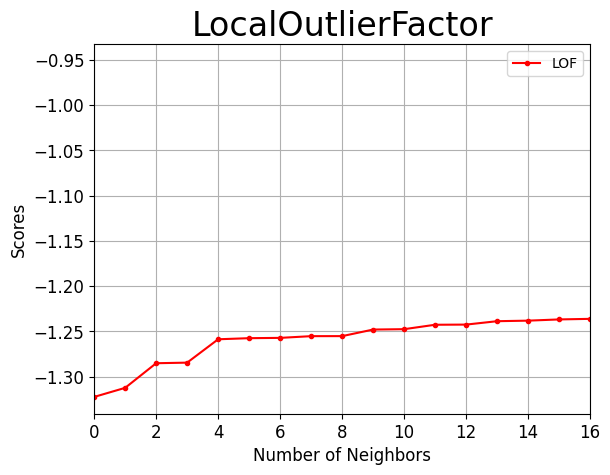

In [30]:
lof = LocalOutlierFactor(n_neighbors=20)
lof.fit_predict(df[num_var])

df_scores = lof.negative_outlier_factor_
print(np.sort(df_scores)[0:6])

scores = pd.DataFrame(np.sort(df_scores))
plt.figure(figsize=(14, 10))
scores.plot(stacked=True, xlim=[0, 16], style=".-", color="red")
plt.title("LocalOutlierFactor", fontsize=24)
plt.xlabel("Number of Neighbors", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.legend(["LOF"])
plt.show()

In [31]:
th = np.sort(df_scores)[3]
th

-1.2844130071114388

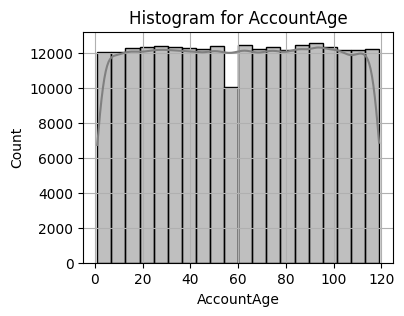

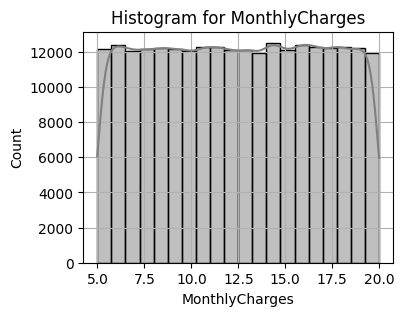

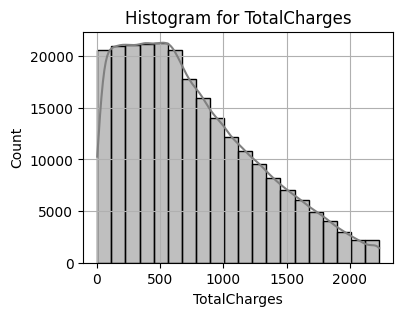

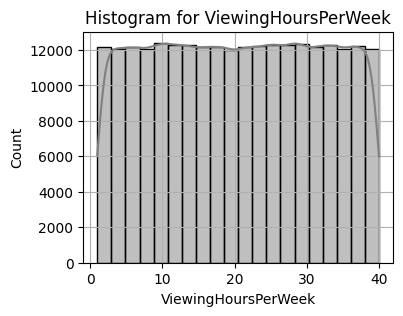

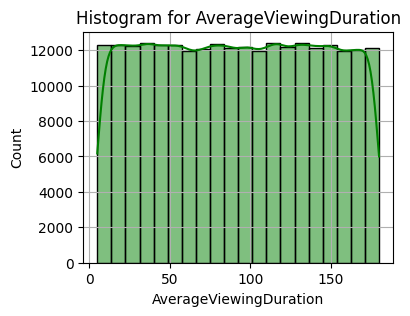

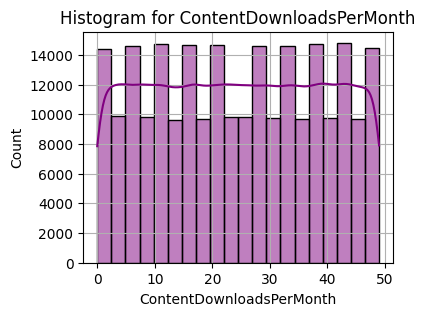

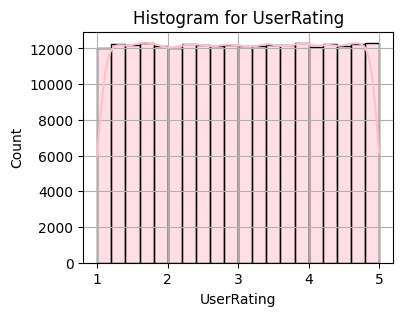

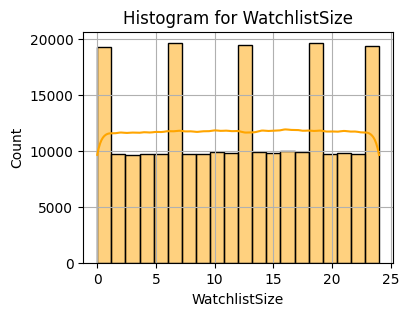

In [100]:
# Analysis of Numeric Variables:
def num_var_anal(dataframe, num_cols):
    
    for i in num_cols:
        plt.figure(figsize=(4, 3))
        sns.histplot(data=dataframe, 
                     x=i, bins=20,
                     color=random.choice(["green", "blue", "red", "gray",
                                          "orange", "pink", "purple"]),
                     kde=True)
        plt.title("Histogram for " + i)
        plt.xlabel(i)
        plt.ylabel("Count")
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid()
        plt.show()

num_var_anal(df, num_var)

In [101]:
import scipy.stats as stats
skewness = df[num_var].skew()
kurtosis = df[num_var].kurtosis()
print("Skewness:\n", skewness)
print("Kurtosis:\n", kurtosis)

Skewness:
 AccountAge                 -0.002506
MonthlyCharges             -0.003584
TotalCharges                0.688936
ViewingHoursPerWeek        -0.001340
AverageViewingDuration      0.002758
ContentDownloadsPerMonth   -0.000427
UserRating                 -0.000958
WatchlistSize              -0.004500
dtype: float64
Kurtosis:
 AccountAge                 -1.199282
MonthlyCharges             -1.201509
TotalCharges               -0.282112
ViewingHoursPerWeek        -1.199817
AverageViewingDuration     -1.200900
ContentDownloadsPerMonth   -1.201353
UserRating                 -1.201812
WatchlistSize              -1.199512
dtype: float64


# In this section, we are also statistically checking whether the variables are normally distributed. For a normal distribution, skewness should be 0 and kurtosis should be -3. If the skewness value is different from 0, then the distribution of the corresponding variable is skewed to the right or left. If the kurtosis value is different from -3, then the distribution of the variable is either peaked or flat at the peak

***********************************************************
                  SubscriptionType      Ratio
SubscriptionType                             
Standard                     81920  33.603104
Basic                        81050  33.246235
Premium                      80817  33.150660


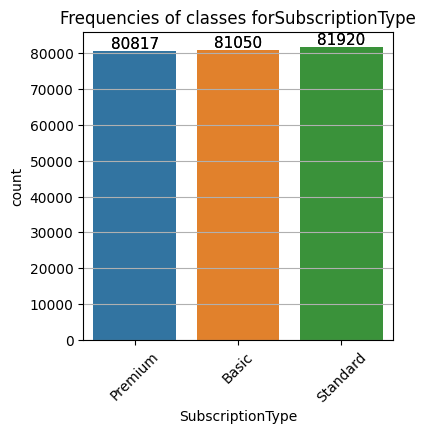

***********************************************************
                  PaymentMethod      Ratio
PaymentMethod                             
Electronic check          61313  25.150234
Credit card               60924  24.990668
Bank transfer             60797  24.938573
Mailed check              60753  24.920525


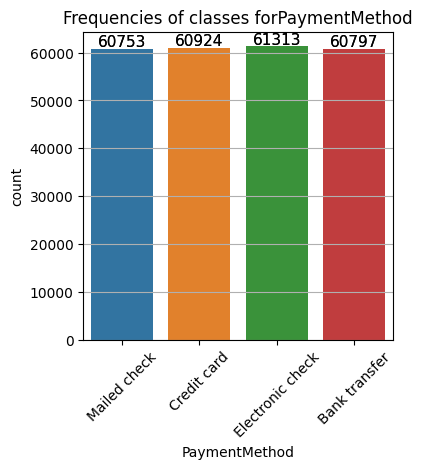

***********************************************************
                  PaperlessBilling      Ratio
PaperlessBilling                             
No                          121980  50.035482
Yes                         121807  49.964518


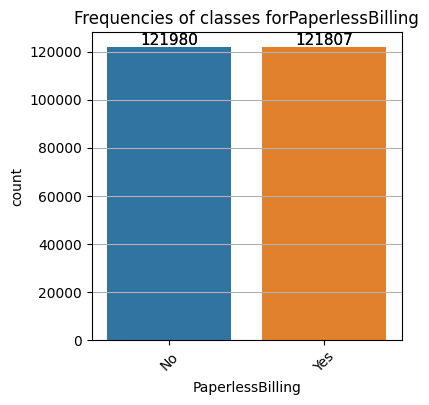

***********************************************************
             ContentType      Ratio
ContentType                        
Both               81737  33.528039
TV Shows           81145  33.285204
Movies             80905  33.186757


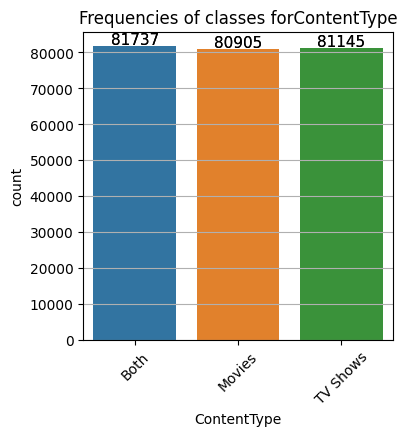

***********************************************************
                   MultiDeviceAccess      Ratio
MultiDeviceAccess                              
No                            122035  50.058042
Yes                           121752  49.941958


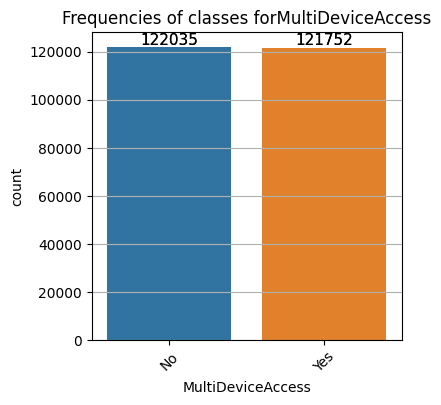

***********************************************************
                  DeviceRegistered      Ratio
DeviceRegistered                             
Computer                     61147  25.082141
Tablet                       61143  25.080501
Mobile                       60914  24.986566
TV                           60583  24.850792


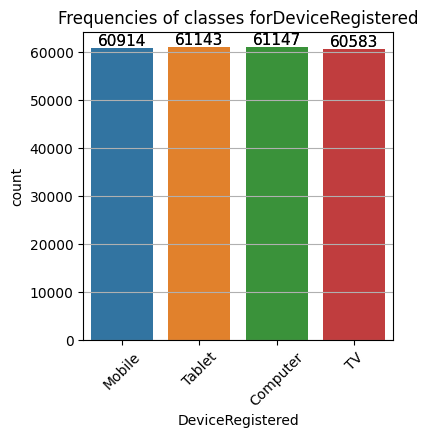

***********************************************************
                 GenrePreference      Ratio
GenrePreference                            
Comedy                     49060  20.124125
Fantasy                    48955  20.081054
Drama                      48744  19.994503
Action                     48690  19.972353
Sci-Fi                     48338  19.827965


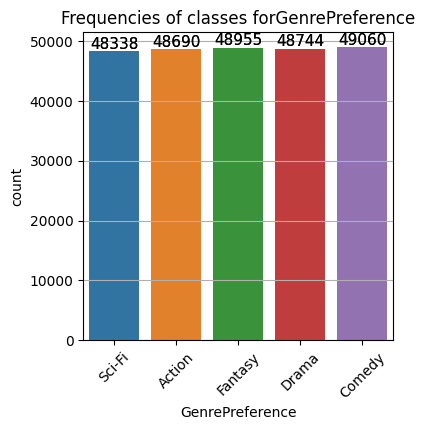

***********************************************************
        Gender      Ratio
Gender                   
Female  121930  50.014972
Male    121857  49.985028


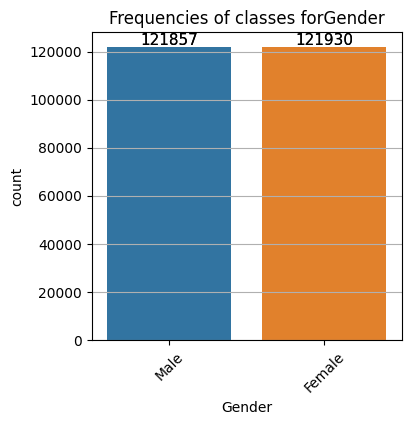

***********************************************************
                 ParentalControl      Ratio
ParentalControl                            
Yes                       122085  50.078552
No                        121702  49.921448


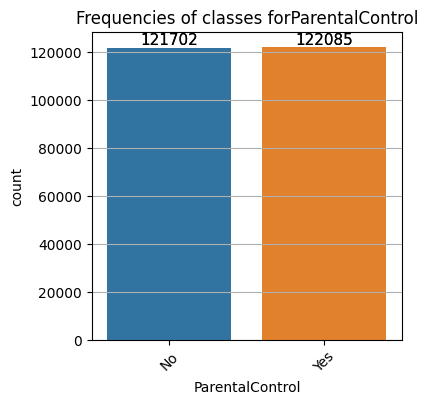

***********************************************************
                  SubtitlesEnabled      Ratio
SubtitlesEnabled                             
Yes                         122180  50.117521
No                          121607  49.882479


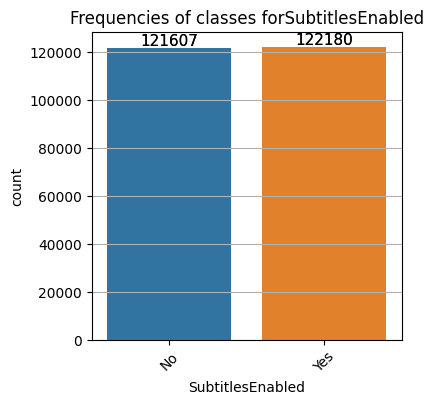

***********************************************************
                        SupportTicketsPerMonth      Ratio
SupportTicketsPerMonth                                   
7                                        24626  10.101441
4                                        24618  10.098159
2                                        24477  10.040322
9                                        24435  10.023094
8                                        24400  10.008737
3                                        24360   9.992329
6                                        24296   9.966077
0                                        24292   9.964436
1                                        24283   9.960744
5                                        24000   9.844659


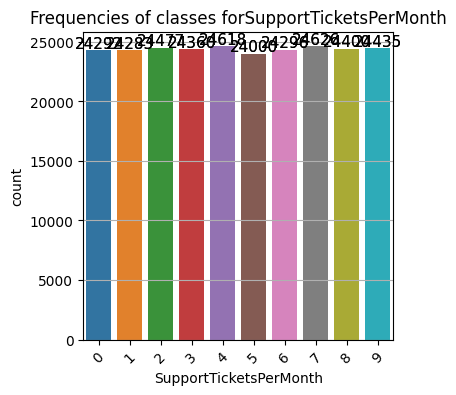

***********************************************************
        Churn      Ratio
Churn                   
0      199605  81.876802
1       44182  18.123198


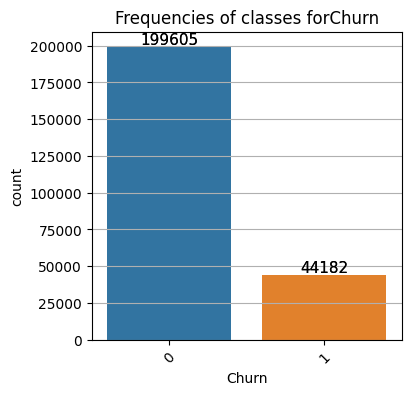

In [102]:
# Analysis of Categoric Variables

def cat_var_anal(dataframe, cat_cols, plot=False):
    for i in cat_cols:
        print("***********************************************************")
        print(pd.DataFrame({i: dataframe[i].value_counts(),
                            "Ratio": dataframe[i].value_counts() * 100 / len(dataframe)}))

        if plot:

            plt.figure(figsize=(4, 4))
            sns.countplot(data=dataframe, x=i)
            plt.title("Frequencies of classes for" + i)
            plt.xlabel(i)
            plt.ylabel("Frequency")
            plt.xticks(fontsize=10, rotation=45)
            plt.yticks(fontsize=10)
            plt.grid()

            ax = sns.countplot(data=dataframe, x=i)
            for p in ax.patches:
                ax.annotate(f'{int(p.get_height())}',
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=11,
                            color='black', xytext=(0, 5),
                            textcoords='offset points')

            plt.show(block=True)

cat_var_anal(df, cat_var, plot=True)

# When we examine the class frequencies of categorical variables, we observe that all classes are the same with each other (except for the target variable). Although our dataset appears balanced, the variable of interest for us, the target variable "Churn", does not have a balanced distribution. As seen, the probability of observing class 0 (i.e., non-churn class) is approximately 82%, while the probability of observing class 1 (i.e., churn class) is approximately 18%. Therefore, our dataset is imbalanced. We should consider this imbalance when building our models later on.

                          AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize
AccountAge                  1.000000        0.001706      0.820367            -0.001640                0.000191                  0.001220    0.000440      -0.002640
MonthlyCharges              0.001706        1.000000      0.498142            -0.003029               -0.000604                 -0.000127    0.000056      -0.000540
TotalCharges                0.820367        0.498142      1.000000            -0.003004                0.000848                  0.000205    0.000596      -0.001778
ViewingHoursPerWeek        -0.001640       -0.003029     -0.003004             1.000000                0.000949                  0.002149   -0.003185      -0.000750
AverageViewingDuration      0.000191       -0.000604      0.000848             0.000949                1.000000                 -0.002397   -0.000406       0.000749
ContentDow

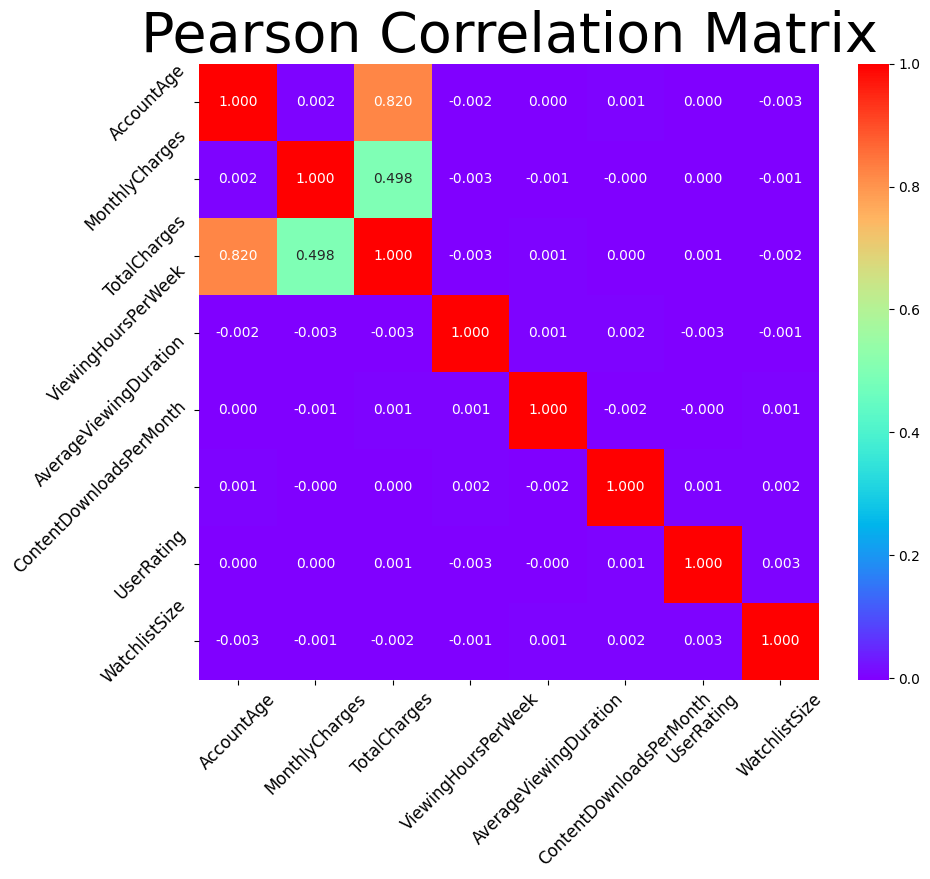

None


In [103]:
# Pearson Correlation Analysis for Numeric Variables
def pearson_corr(dataframe, num_cols, plot=False):

    print(df[num_cols].corr())

    if plot:
        plt.figure(figsize=[10, 8])
        sns.heatmap(data=dataframe[num_cols].corr(), annot=True, fmt=".3f",
                    linecolor="pink", cmap="rainbow")
        plt.xticks(rotation=45, fontsize=12)
        plt.yticks(rotation=45, fontsize=12)
        plt.title("Pearson Correlation Matrix", fontsize=40)
        print(plt.show())

pearson_corr(df, num_var, plot=True)


# Correlation analysis shows us the relationship between variables. A correlation value takes a value between -1 and +1. The closer the value is to -1 or +1, the stronger the relationship between those two variables is. The positive or negative sign indicates the direction of the relationship. For example, a negative sign indicates an inverse relationship between the two variables, while a positive sign indicates a positive or direct relationship between the two variables.

******************
Churn & AccountAge--> -0.19773563199738664
******************
Churn & MonthlyCharges--> 0.1004728066286877
******************
Churn & TotalCharges--> -0.12057564405005607
******************
Churn & ViewingHoursPerWeek--> -0.1286448060396314
******************
Churn & AverageViewingDuration--> -0.14689656866689915
******************
Churn & ContentDownloadsPerMonth--> -0.12975187419254758
******************
Churn & UserRating--> 0.022123581084266878
******************
Churn & WatchlistSize--> 0.021738674917027835


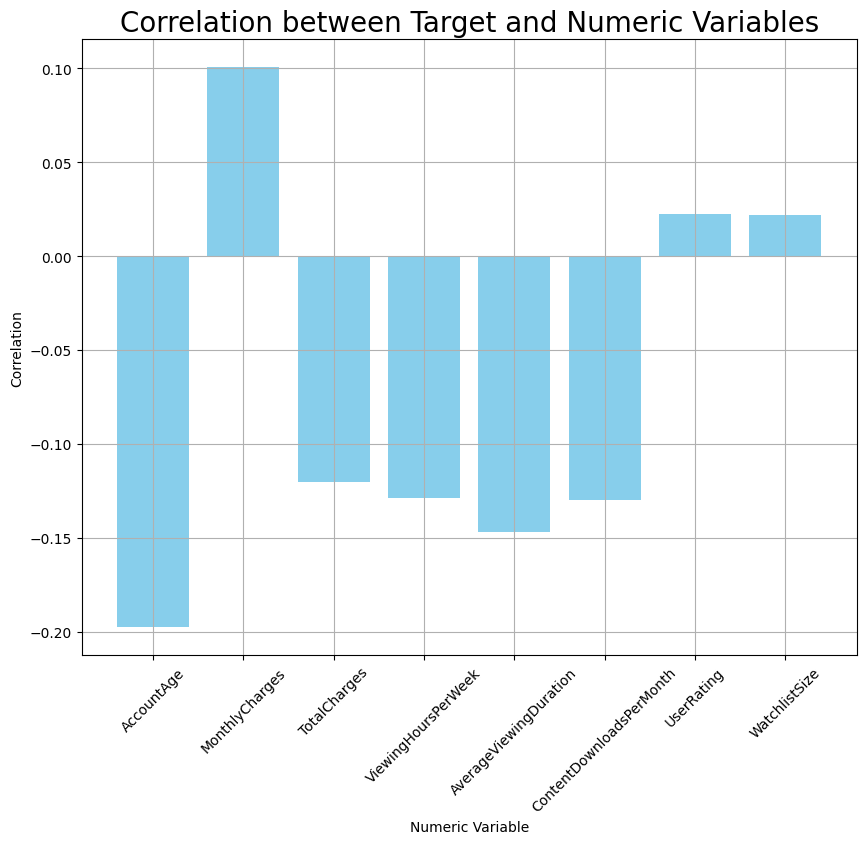

In [104]:
# Analysis of correlation between the Target and Numeric Variables
for i in num_var:
    print("******************")
    print("Churn & " + i + "-->", df["Churn"].corr(df[i]))

correlations = {i: df["Churn"].corr(df[i]) for i in num_var}

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(correlations.keys(), correlations.values(), color='skyblue')
plt.title('Correlation between Target and Numeric Variables', fontsize=20)
plt.xlabel('Numeric Variable')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.grid()
plt.show()

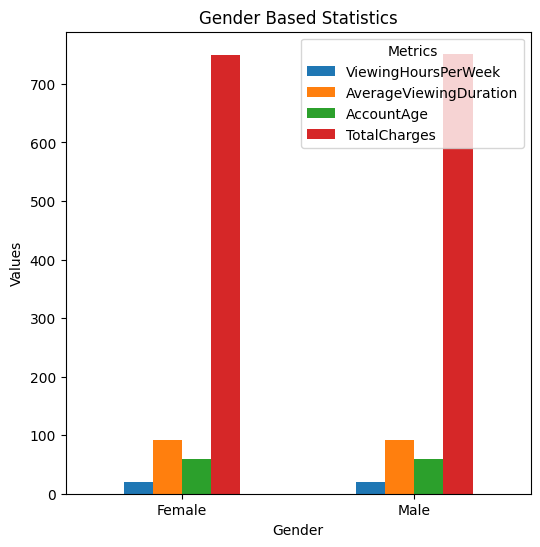

In [105]:
# Understanding of Data Set
grouped_data = df.groupby("Gender").agg({"ViewingHoursPerWeek": "mean",
                                         "AverageViewingDuration": "mean",
                                         "AccountAge": "mean",
                                         "TotalCharges": "mean"})

grouped_data.plot(kind="bar", figsize=(6, 6))
plt.title("Gender Based Statistics")
plt.xlabel("Gender")
plt.ylabel("Values")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()

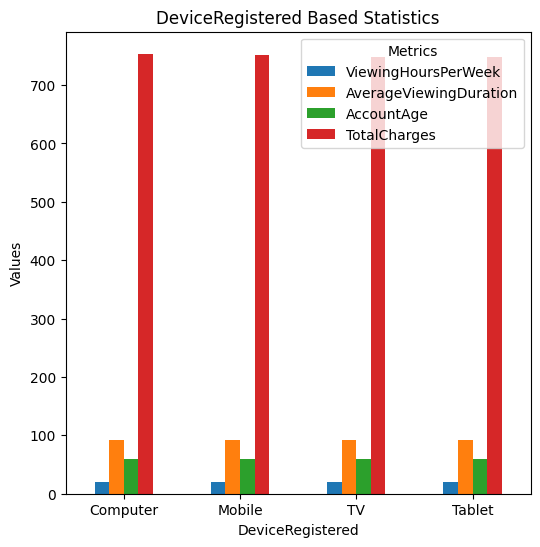

In [106]:
grouped_data = df.groupby("DeviceRegistered").agg({"ViewingHoursPerWeek": "mean",
                                                  "AverageViewingDuration": "mean",
                                                  "AccountAge": "mean",
                                                  "TotalCharges": "mean"})

grouped_data.plot(kind="bar", figsize=(6, 6))
plt.title("DeviceRegistered Based Statistics")
plt.xlabel("DeviceRegistered")
plt.ylabel("Values")
plt.xticks(rotation=0)
plt.legend(title="Metrics")
plt.show()

# Feature Extraction

In [32]:
# Segmentation of AccountAge
print(df["AccountAge"].describe().T)

labels = ["new_customer", "standard_customer", "old_customer"]

bins = [df["AccountAge"].min() - 1,
        24, 60,
        df["AccountAge"].max() + 1]

df["AccountAge_Segment"] = pd.cut(x=df["AccountAge"], bins=bins, labels=labels)

print(df.groupby("AccountAge_Segment").agg({"ViewingHoursPerWeek": "mean",
                                           "AverageViewingDuration": "mean",
                                           "ContentDownloadsPerMonth": ["mean", "count"]}))

count    243787.000000
mean         60.083758
std          34.285143
min           1.000000
25%          30.000000
50%          60.000000
75%          90.000000
max         119.000000
Name: AccountAge, dtype: float64
                   ViewingHoursPerWeek AverageViewingDuration ContentDownloadsPerMonth        
                                  mean                   mean                     mean   count
AccountAge_Segment                                                                            
new_customer                 20.507195              92.483013                24.548743   48786
standard_customer            20.532669              92.123164                24.480652   73856
old_customer                 20.481571              92.261785                24.499236  121145


In [33]:
# Segmentation of ViewingHoursPerWeek
print(df["ViewingHoursPerWeek"].describe().T)

labels = ["less_watcher", "watcher", "hard_watcher"]

bins = [df["ViewingHoursPerWeek"].min() - 1,
        df["ViewingHoursPerWeek"].quantile(0.25),
        df["ViewingHoursPerWeek"].quantile(0.75),
        df["ViewingHoursPerWeek"].max() + 1]

df["ViewingHoursPerWeek_Segment"] = pd.cut(x=df["ViewingHoursPerWeek"], bins=bins, labels=labels)

print(df.groupby("ViewingHoursPerWeek_Segment").agg({"ViewingHoursPerWeek": "mean",
                                           "AverageViewingDuration": "mean",
                                           "ContentDownloadsPerMonth": ["mean", "count"]}))

count    243787.000000
mean         20.502179
std          11.243753
min           1.000065
25%          10.763953
50%          20.523116
75%          30.219396
max          39.999723
Name: ViewingHoursPerWeek, dtype: float64
                            ViewingHoursPerWeek AverageViewingDuration ContentDownloadsPerMonth        
                                           mean                   mean                     mean   count
ViewingHoursPerWeek_Segment                                                                            
less_watcher                           5.897958              92.000918                24.469506   60947
watcher                               20.505635              92.450099                24.496288  121893
hard_watcher                          35.099489              92.155133                24.551971   60947


In [34]:
# Creating Child and Adult Classes by ParentalControl and Gender
df.loc[(df["ParentalControl"] == "Yes") & (df["Gender"] == "Male"), "Age_Gender_Segment"] = "Child_Male"
df.loc[(df["ParentalControl"] == "Yes") & (df["Gender"] == "Female"), "Age_Gender_Segment"] = "Child_Female"
df.loc[(df["ParentalControl"] == "No") & (df["Gender"] == "Male"), "Age_Gender_Segment"] = "Adult_Male"
df.loc[(df["ParentalControl"] == "No") & (df["Gender"] == "Female"), "Age_Gender_Segment"] = "Adult_Female"

print(df.groupby("Age_Gender_Segment").agg({"ViewingHoursPerWeek": "mean",
                                           "AverageViewingDuration": "mean",
                                           "ContentDownloadsPerMonth": ["mean", "count"]}))

                   ViewingHoursPerWeek AverageViewingDuration ContentDownloadsPerMonth       
                                  mean                   mean                     mean  count
Age_Gender_Segment                                                                           
Adult_Female                 20.568803              92.056005                24.556317  60825
Adult_Male                   20.487791              92.484685                24.459878  60877
Child_Female                 20.485138              92.296616                24.525685  61105
Child_Male                   20.467164              92.218715                24.472188  60980


In [35]:
# Grouping SupportTicketsPerMonth

print("Number of Unique-->", df["SupportTicketsPerMonth"].nunique())

print("Value Counts\n", df["SupportTicketsPerMonth"].value_counts())

print(df.groupby("SupportTicketsPerMonth").agg({"MonthlyCharges": "mean",
                                          "ViewingHoursPerWeek": "mean",
                                          "Churn": ["mean", "count"]}))

df.loc[(6 > df["SupportTicketsPerMonth"]) & (df["SupportTicketsPerMonth"] >= 0), "New_SupportTicketsPerMonth"] = 0

df.loc[(df["SupportTicketsPerMonth"] >= 6), "New_SupportTicketsPerMonth"] = 1
df.head()

Number of Unique--> 10
Value Counts
 SupportTicketsPerMonth
7    24626
4    24618
2    24477
9    24435
8    24400
3    24360
6    24296
0    24292
1    24283
5    24000
Name: count, dtype: int64
                       MonthlyCharges ViewingHoursPerWeek     Churn       
                                 mean                mean      mean  count
SupportTicketsPerMonth                                                    
0                           12.470947           20.632531  0.133583  24292
1                           12.452410           20.433606  0.145081  24283
2                           12.490431           20.421323  0.152020  24477
3                           12.509898           20.369845  0.161289  24360
4                           12.535406           20.630899  0.174547  24618
5                           12.510057           20.388707  0.182750  24000
6                           12.530725           20.636210  0.196041  24296
7                           12.484640           20.458

AccountAge  MonthlyCharges  TotalCharges SubscriptionType     PaymentMethod PaperlessBilling ContentType MultiDeviceAccess DeviceRegistered  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth GenrePreference  UserRating  SupportTicketsPerMonth  Gender  WatchlistSize ParentalControl SubtitlesEnabled  CustomerID  Churn AccountAge_Segment ViewingHoursPerWeek_Segment Age_Gender_Segment  New_SupportTicketsPerMonth
0          20       11.055215    221.104302          Premium      Mailed check               No        Both                No           Mobile            36.758104               63.531377                        10          Sci-Fi    2.176498                       4    Male              3              No               No  CB6SXPNVZA      0       new_customer                hard_watcher         Adult_Male                         0.0
1          57        5.175208    294.986882            Basic       Credit card              Yes      Movies                No           Tablet            32.450568               25.725595                        18          Action    3.478632                       8    Male             23              No              Yes  S7R2G87O09      0  standard_customer                hard_watcher         Adult_Male                         1.0
2          73       12.106657    883.785952            Basic      Mailed check              Yes      Movies                No         Computer             7.395160               57.364061                        23         Fantasy    4.238824                       6    Male              1             Yes              Yes  EASDC20BDT      0       old_customer                less_watcher         Child_Male                         1.0
3          32        7.263743    232.439774            Basic  Electronic check               No    TV Shows                No           Tablet            27.960389              131.537507                        30           Drama    4.276013                       2    Male             24             Yes              Yes  NPF69NT69N      0  standard_customer                     watcher         Child_Male                         0.0
4          57       16.953078    966.325422          Premium  Electronic check              Yes    TV Shows                No               TV            20.083397               45.356653                        20          Comedy    3.616170                       4  Female              0              No               No  4LGYPK7VOL      0  standard_customer                     watcher       Adult_Female                         0.0

In [36]:
df.drop("SupportTicketsPerMonth", axis=1, inplace=True)

# Encdoing

# OneHot Encoding is a method that creates a new variable for each class of categorical variables and represents the values numerically (0, 1). It is a crucial step to apply encoding to the dataset in order to represent all variables numerically for feeding our data into a machine learning model. When we set the drop_first argument to True, it prevents the creation of a variable for the first class in alphabetical order of the respective categorical variable. Thus, it helps to prevent measurement problems resulting from generating variables over each other for binary categorical variables.

In [37]:
cat_var, cat_but_car, num_var = grab_variable(df)
cat_var.remove("Churn")

df = pd.get_dummies(data=df, columns=cat_var, drop_first=True, dtype="int64")

Observation: 243787
Number of Variables: 24
Number of Categoric Variables: 15
Number of Num but Cat Variables: 2
Number of Cat but Cardinal Variables: 1
Number of Numeric Variables: 8


In [38]:
df.head()

AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize  CustomerID  Churn  SubscriptionType_Premium  SubscriptionType_Standard  PaymentMethod_Credit card  PaymentMethod_Electronic check  PaymentMethod_Mailed check  PaperlessBilling_Yes  ContentType_Movies  ContentType_TV Shows  MultiDeviceAccess_Yes  DeviceRegistered_Mobile  DeviceRegistered_TV  DeviceRegistered_Tablet  GenrePreference_Comedy  GenrePreference_Drama  GenrePreference_Fantasy  GenrePreference_Sci-Fi  Gender_Male  ParentalControl_Yes  SubtitlesEnabled_Yes  AccountAge_Segment_standard_customer  AccountAge_Segment_old_customer  \
0          20       11.055215    221.104302            36.758104               63.531377                        10    2.176498              3  CB6SXPNVZA      0                         1                          0                          0                               0                           1                     0                   0                     0                      0                        1                    0                        0                       0                      0                        0                       1            1                    0                     0                                     0                                0   
1          57        5.175208    294.986882            32.450568               25.725595                        18    3.478632             23  S7R2G87O09      0                         0                          0                          1                               0                           0                     1                   1                     0                      0                        0                    0                        1                       0                      0                        0                       0            1                    0                     1                                     1                                0   
2          73       12.106657    883.785952             7.395160               57.364061                        23    4.238824              1  EASDC20BDT      0                         0                          0                          0                               0                           1                     1                   1                     0                      0                        0                    0                        0                       0                      0                        1                       0            1                    1                     1                                     0                                1   
3          32        7.263743    232.439774            27.960389              131.537507                        30    4.276013             24  NPF69NT69N      0                         0                          0                          0                               1                           0                     0                   0                     1                      0                        0                    0                        1                       0                      1                        0                       0            1                    1                     1                                     1                                0   
4          57       16.953078    966.325422            20.083397               45.356653                        20    3.616170              0  4LGYPK7VOL      0                         1                          0                          0                               1                           0                     1                   0                     1                      0                        0                    1                        0                       1                      0                        0                       0            0           

Observation: 243787
Number of Variables: 37
Number of Categoric Variables: 28
Number of Num but Cat Variables: 28
Number of Cat but Cardinal Variables: 1
Number of Numeric Variables: 8


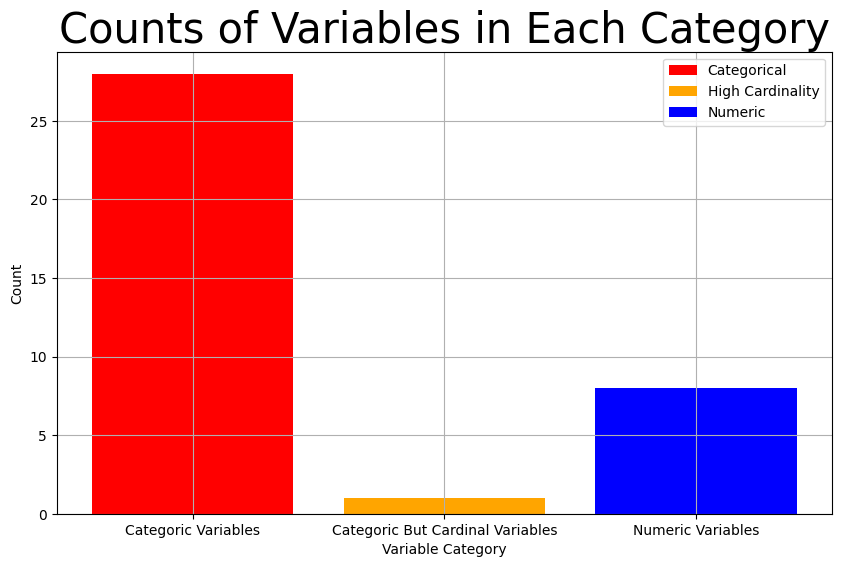

In [39]:
cat_var, cat_but_car, num_var = grab_variable(df)
plot_variable_counts(cat_var, cat_but_car, num_var)

In [40]:
df.head()

AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize  CustomerID  Churn  SubscriptionType_Premium  SubscriptionType_Standard  PaymentMethod_Credit card  PaymentMethod_Electronic check  PaymentMethod_Mailed check  PaperlessBilling_Yes  ContentType_Movies  ContentType_TV Shows  MultiDeviceAccess_Yes  DeviceRegistered_Mobile  DeviceRegistered_TV  DeviceRegistered_Tablet  GenrePreference_Comedy  GenrePreference_Drama  GenrePreference_Fantasy  GenrePreference_Sci-Fi  Gender_Male  ParentalControl_Yes  SubtitlesEnabled_Yes  AccountAge_Segment_standard_customer  AccountAge_Segment_old_customer  \
0          20       11.055215    221.104302            36.758104               63.531377                        10    2.176498              3  CB6SXPNVZA      0                         1                          0                          0                               0                           1                     0                   0                     0                      0                        1                    0                        0                       0                      0                        0                       1            1                    0                     0                                     0                                0   
1          57        5.175208    294.986882            32.450568               25.725595                        18    3.478632             23  S7R2G87O09      0                         0                          0                          1                               0                           0                     1                   1                     0                      0                        0                    0                        1                       0                      0                        0                       0            1                    0                     1                                     1                                0   
2          73       12.106657    883.785952             7.395160               57.364061                        23    4.238824              1  EASDC20BDT      0                         0                          0                          0                               0                           1                     1                   1                     0                      0                        0                    0                        0                       0                      0                        1                       0            1                    1                     1                                     0                                1   
3          32        7.263743    232.439774            27.960389              131.537507                        30    4.276013             24  NPF69NT69N      0                         0                          0                          0                               1                           0                     0                   0                     1                      0                        0                    0                        1                       0                      1                        0                       0            1                    1                     1                                     1                                0   
4          57       16.953078    966.325422            20.083397               45.356653                        20    3.616170              0  4LGYPK7VOL      0                         1                          0                          0                               1                           0                     1                   0                     1                      0                        0                    1                        0                       1                      0                        0                       0            0           

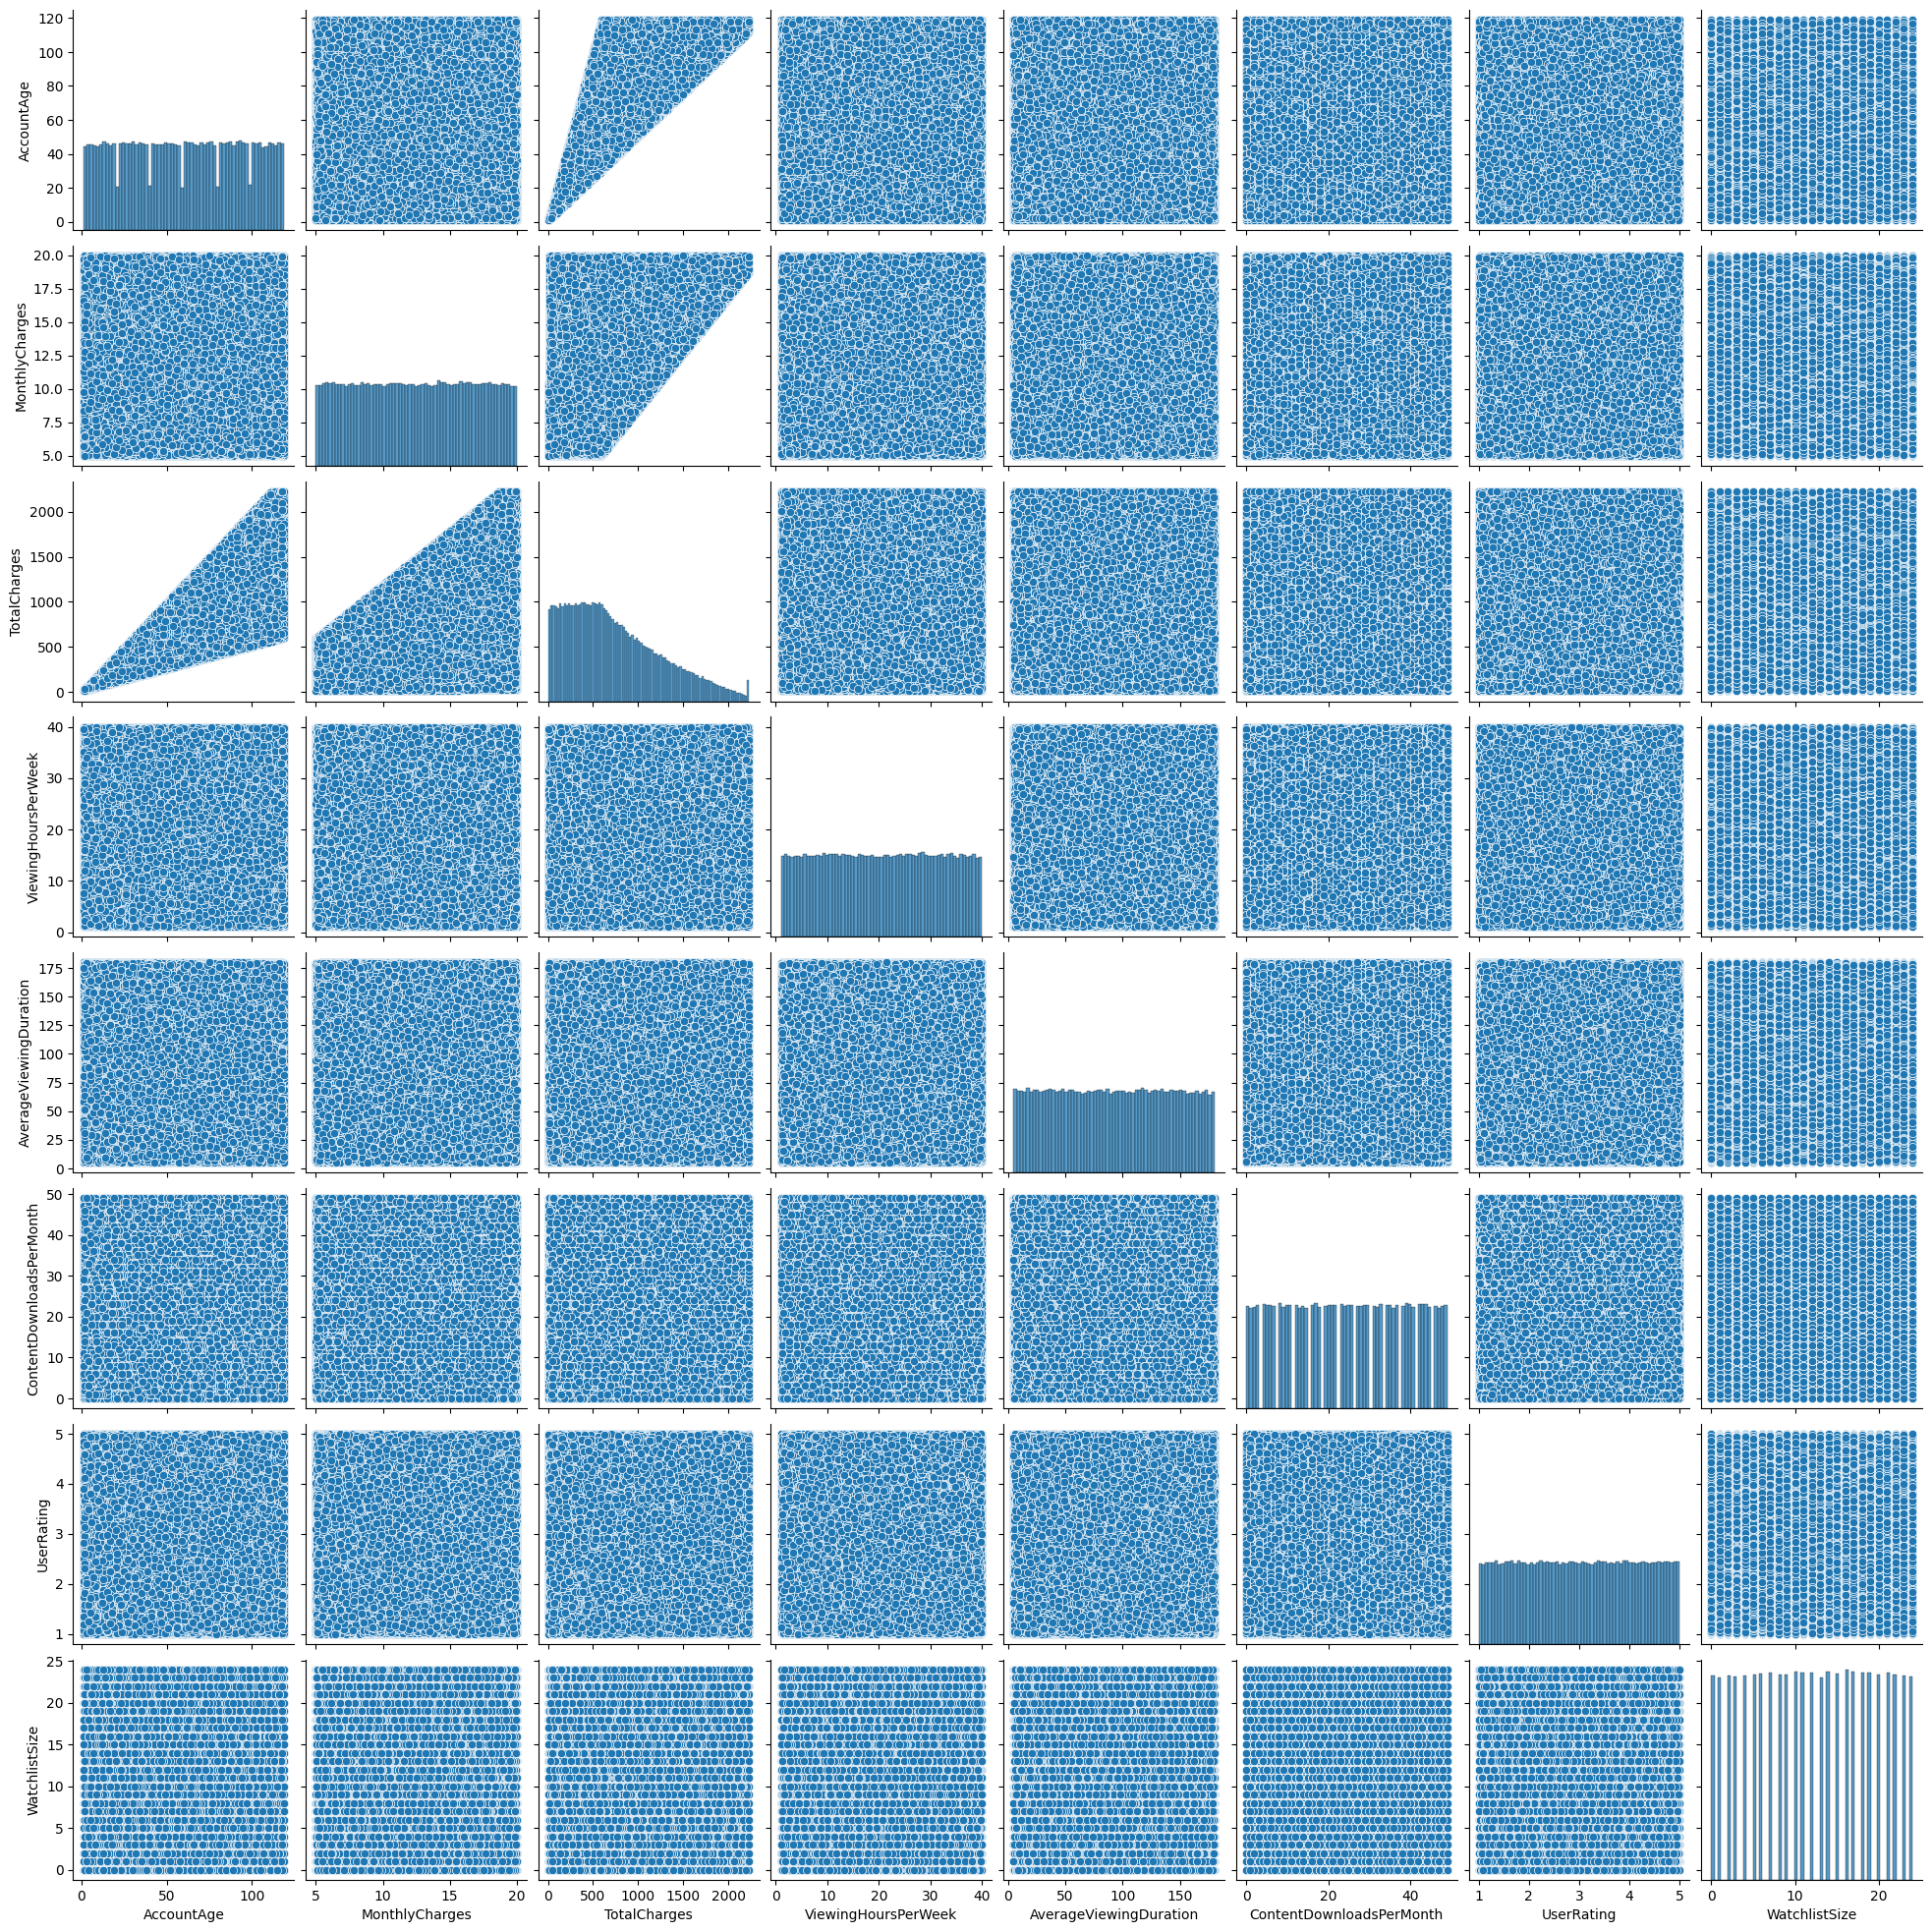

In [115]:
sns.pairplot(data=df[num_var])
plt.show()

# Scaling

# The Standard Scaler is used for standardization and is highly affected by outliers, making it suitable for datasets that exhibit a distribution close to normal. This process is applied to all numerical variables, transforming them to have a mean of 0 and a standard deviation of 1. It can yield negative values.

# The MinMax Scaler, also known as normalization, is similarly impacted by outliers and is suitable for datasets that demonstrate a distribution close to normal. Typically, it scales values to fit within the range of 0 to 1, although this range can be adjusted by the user. It preserves the originality of the data.

# The Robust Scaler is resilient against outliers. Since our dataset does not contain outliers, there is not much need to use it.

In [41]:
def standardization(dataframe, variable, select=1):
    if select == 1:
        ss = StandardScaler()
        dataframe[variable] = ss.fit_transform(dataframe[variable])
    elif select == 2:
        mms = MinMaxScaler()
        dataframe[variable] = mms.fit_transform(dataframe[variable])
    elif select == 3:
        rs = RobustScaler()
        dataframe[variable] = rs.fit_transform(dataframe[variable])
    else:
        print("Please Enter Correct Number for Scaling")

standardization(df, num_var)

In [42]:
df.head()

AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize  CustomerID  Churn  SubscriptionType_Premium  SubscriptionType_Standard  PaymentMethod_Credit card  PaymentMethod_Electronic check  PaymentMethod_Mailed check  PaperlessBilling_Yes  ContentType_Movies  ContentType_TV Shows  MultiDeviceAccess_Yes  DeviceRegistered_Mobile  DeviceRegistered_TV  DeviceRegistered_Tablet  GenrePreference_Comedy  GenrePreference_Drama  GenrePreference_Fantasy  GenrePreference_Sci-Fi  Gender_Male  ParentalControl_Yes  SubtitlesEnabled_Yes  AccountAge_Segment_standard_customer  AccountAge_Segment_old_customer  \
0   -1.169131       -0.331703     -1.013161             1.445777               -0.568906                 -1.005712   -0.715179      -1.253786  CB6SXPNVZA      0                         1                          0                          0                               0                           1                     0                   0                     0                      0                        1                    0                        0                       0                      0                        0                       1            1                    0                     0                                     0                                0   
1   -0.089945       -1.690423     -0.871785             1.062671               -1.317459                 -0.450971    0.411960       1.526687  S7R2G87O09      0                         0                          0                          1                               0                           0                     1                   1                     0                      0                        0                    0                        1                       0                      0                        0                       0            1                    0                     1                                     1                                0   
2    0.376731       -0.088741      0.254900            -1.165718               -0.691019                 -0.104258    1.069988      -1.531833  EASDC20BDT      0                         0                          0                          0                               0                           1                     1                   1                     0                      0                        0                    0                        0                       0                      0                        1                       0            1                    1                     1                                     0                                1   
3   -0.819125       -1.207816     -0.991470             0.663322                0.777613                  0.381141    1.102179       1.665711  NPF69NT69N      0                         0                          0                          0                               1                           0                     0                   0                     1                      0                        0                    0                        1                       0                      1                        0                       0            1                    1                     1                                     1                                0   
4   -0.089945        1.031143      0.412842            -0.037246               -0.928765                 -0.312285    0.531014      -1.670857  4LGYPK7VOL      0                         1                          0                          0                               1                           0                     1                   0                     1                      0                        0                    1                        0                       1                      0                        0                       0            0           

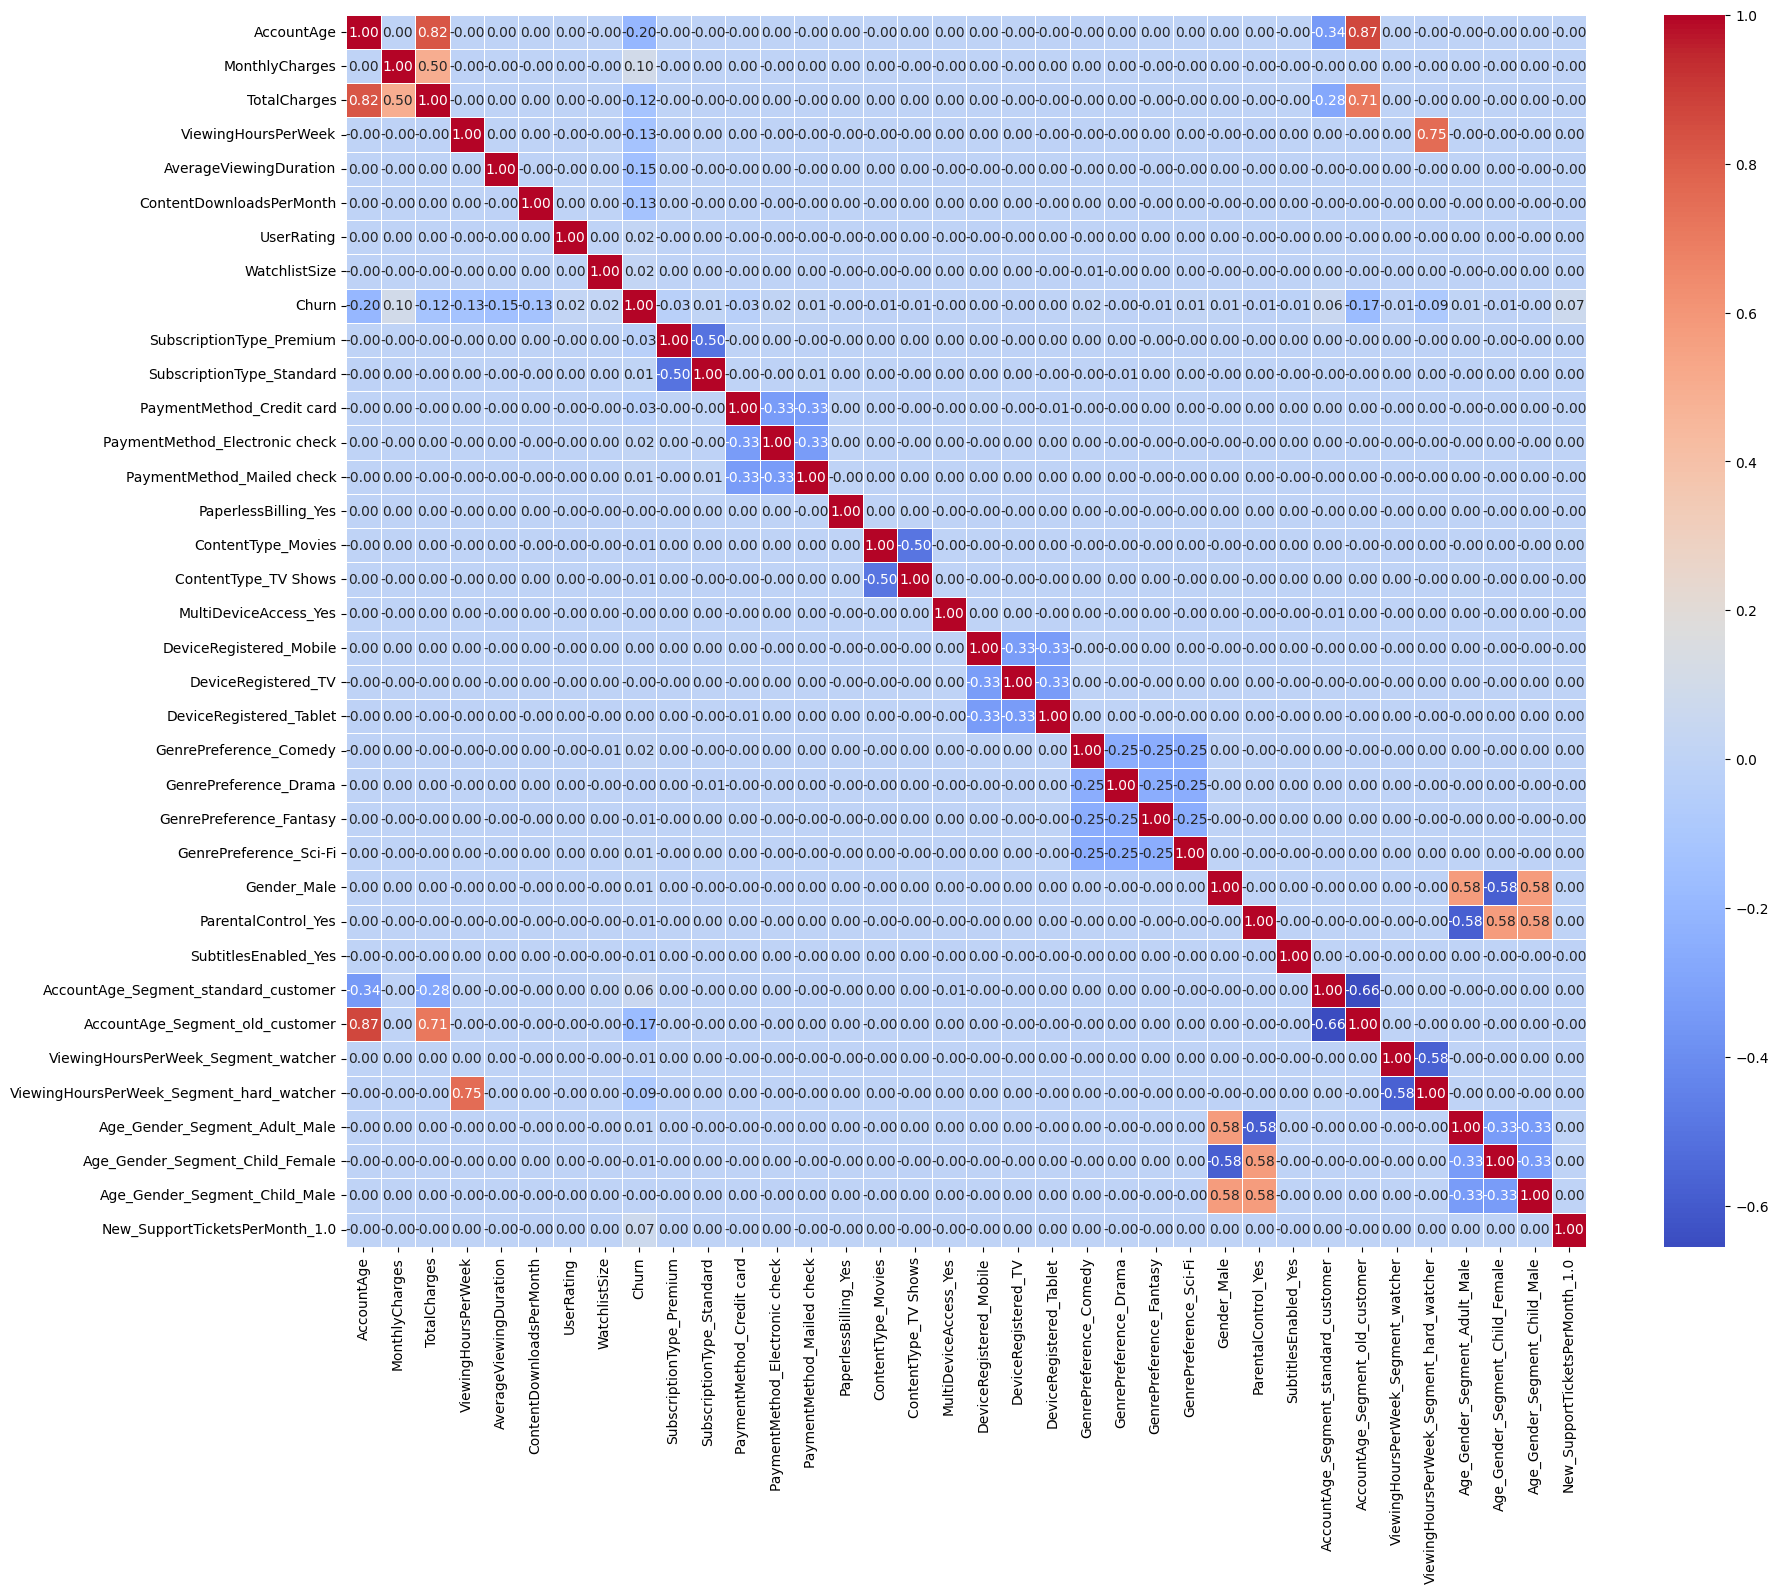

In [43]:
df.drop("CustomerID", axis=1, inplace=True)

plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.show()

# Primitive Machine Learning Models 

In [119]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

models = [('LOG', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ("AdaBoost", AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ("XGBoost", XGBRFClassifier(objective='reg:squarederror')),
          ("LightGBM", LGBMClassifier())]

f1_score_list = []

for name, clf in models:
    acc = cross_validate(clf, 
                        X_test, y_test,
                        cv=3,
                        scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    
    print("Accuracy-->", round(acc["test_accuracy"].mean(), 4), name)
    print("Precision-->", round(acc["test_precision"].mean(), 4), name)
    print("Recall-->", round(acc["test_recall"].mean(), 4), name)
    print("f1-->", round(acc["test_f1"].mean(), 4), name)
    print("roc_auc-->", round(acc["test_roc_auc"].mean(), 4), name)
    
    f1_score_list.append(acc["test_f1"].mean())
    f1_score_list.append(name)

print(f1_score_list)

Accuracy--> 0.8248 LOG
Precision--> 0.5646 LOG
Recall--> 0.1149 LOG
f1--> 0.1908 LOG
roc_auc--> 0.7499 LOG
Accuracy--> 0.8015 KNN
Precision--> 0.3693 KNN
Recall--> 0.1446 KNN
f1--> 0.2078 KNN
roc_auc--> 0.6297 KNN
Accuracy--> 0.7313 CART
Precision--> 0.2736 CART
Recall--> 0.2984 CART
f1--> 0.2854 CART
roc_auc--> 0.5623 CART
Accuracy--> 0.8217 RF
Precision--> 0.5441 RF
Recall--> 0.0581 RF
f1--> 0.1049 RF
roc_auc--> 0.7247 RF
Accuracy--> 0.8228 AdaBoost
Precision--> 0.5327 AdaBoost
Recall--> 0.1251 AdaBoost
f1--> 0.2024 AdaBoost
roc_auc--> 0.7417 AdaBoost
Accuracy--> 0.8238 GBM
Precision--> 0.5624 GBM
Recall--> 0.0947 GBM
f1--> 0.1621 GBM
roc_auc--> 0.7451 GBM
Accuracy--> 0.8221 XGBoost
Precision--> 0.5815 XGBoost
Recall--> 0.0437 XGBoost
f1--> 0.0812 XGBoost
roc_auc--> 0.7294 XGBoost
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7313, number of negative: 33318
[LightGBM] [Info] Auto-choosing row-wise multi-threading

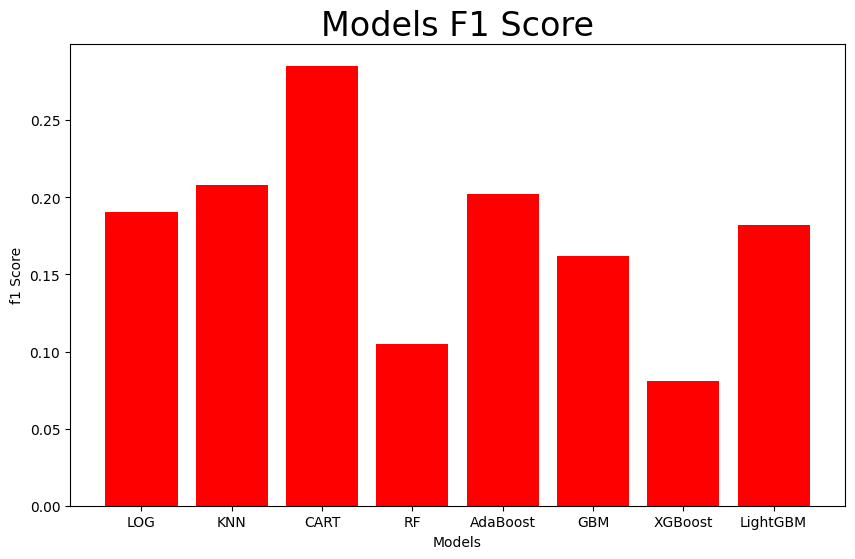

In [120]:
models = f1_score_list[1::2]
f1_scores = f1_score_list[::2]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color="red")
plt.xlabel('Models')
plt.ylabel('f1 Score')
plt.title('Models F1 Score', fontsize=24)
plt.show()


The SMOTE method is used for improving predictions of the minority class in imbalanced datasets, contributing to the overall model performance.

The working principle of the SMOTE method is as follows:

It takes each example from the minority class and creates new synthetic data by examining the similarities between these examples.
It balances the number of observations belonging to the minority class to be equal to the majority class initially and mitigates the class imbalance.
SMOTE does not produce any duplicate data.

# SMOTE DecisionTree

*** After sampling ***
Percentage of 'Churn': 18.123197709475892
Percentage of 'Not Churn': 81.87680229052411


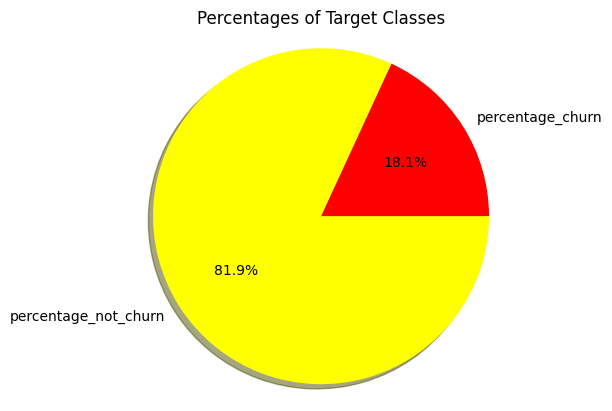

In [121]:
# PIE CHART
churn_count = (df['Churn'] == 1).sum()
not_churn_count = (df['Churn'] == 0).sum()

total_count = len(df)

percentage_churn = (churn_count / total_count) * 100
percentage_not_churn = (not_churn_count / total_count) * 100
print("*** After sampling ***")
print("Percentage of 'Churn':", percentage_churn)
print("Percentage of 'Not Churn':", percentage_not_churn)

# Pasta Grafiği Oluşturma
labels = ['percentage_churn', 'percentage_not_churn']
sizes = [percentage_churn, percentage_not_churn]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        colors=["red", "yellow"],
        shadow=True)
plt.axis('equal')
plt.title("Percentages of Target Classes")
plt.show()

In [122]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.concat([X_train_resampled, pd.Series(y_train_resampled, name='Churn')], axis=1)

X_resampled = resampled_data.drop('Churn', axis=1)
y_resampled = resampled_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.25,
                                                    random_state=42)

*** After sampling ***
Percentage of 'Churn': 50.0
Percentage of 'Not Churn': 50.0


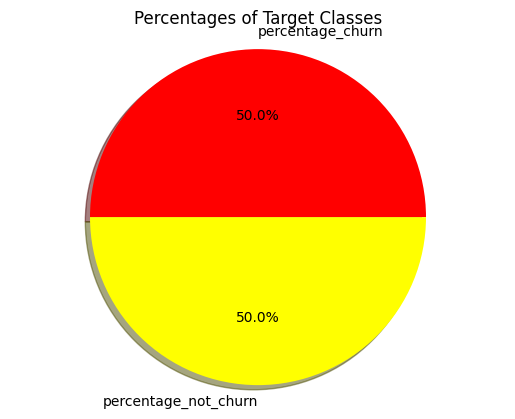

In [123]:
# PIE CHART
churn_count = (resampled_data['Churn'] == 1).sum()
not_churn_count = (resampled_data['Churn'] == 0).sum()

total_count = len(resampled_data)

percentage_churn = (churn_count / total_count) * 100
percentage_not_churn = (not_churn_count / total_count) * 100
print("*** After sampling ***")
print("Percentage of 'Churn':", percentage_churn)
print("Percentage of 'Not Churn':", percentage_not_churn)

# Pasta Grafiği Oluşturma
labels = ['percentage_churn', 'percentage_not_churn']
sizes = [percentage_churn, percentage_not_churn]
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        colors=["red", "yellow"],
        shadow=True)
plt.axis('equal')
plt.title("Percentages of Target Classes")
plt.show()

# SMOTE Random Forests

In [124]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [125]:
# Test Set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
y_prob = model.predict_proba(X_test)[:, 1] # probability of class 1 occurs
print("Roc_AUC-->", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     37281
           1       0.85      0.87      0.86     37533

    accuracy                           0.86     74814
   macro avg       0.86      0.86      0.86     74814
weighted avg       0.86      0.86      0.86     74814

Roc_AUC--> 0.9358902815236924


The ROC AUC score is one of the most important metrics used to evaluate the performance of a model, especially for imbalanced datasets. The ROC curve evaluates the model by trying different classification threshold values. The AUC (Area Under the Curve) calculates the area under these curves (through integration), providing a single value. It examines the relationship between the "true positive rate" and the "true negative rate", ranging between 0 and 1. The closer the score is to 1, the better the performance of the model.

In [126]:
# Train Set
y_pred_train = model.predict(X_train)
print(classification_report(y_train, y_pred_train))
y_prob_train = model.predict_proba(X_train)[:, 1]
print("ROC_AUC-->", roc_auc_score(y_train, y_prob_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    112346
           1       1.00      1.00      1.00    112094

    accuracy                           1.00    224440
   macro avg       1.00      1.00      1.00    224440
weighted avg       1.00      1.00      1.00    224440

ROC_AUC--> 0.9999999999999999


# Model is in overfitting. We should fix it!

In [127]:
# Parameters
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Hyperparameter Optimization w RandomizedSearchCV

**In RandomForest models, hyperparameter optimization takes a considerable amount of time. For this reason, we initially perform hyperparameter tuning with RandomizedSearchCV. This method does not try all possibilities like GridSearchCV does, hence it runs faster but may not find the best results.**

In [134]:
params = {"max_depth": range(2, 15),  #  branching and depth of the tree
          "n_estimators": range(10, 50),  # number of created trees
          "min_samples_split": [2, 3, 4],  # minimum sample for splitting nodes
          "max_features": ["sqrt", "log", None,  "auto"],  # Maximum number of features to consider in each split
          "criterion": ["gini", "entropy"]}  # Splitting Criterions

rf_random = RandomizedSearchCV(estimator=model,  # ML Model
                               param_distributions=params,  # hiperparameters
                               n_iter=20,  # number of iterations (keep low for random forests model)
                               cv=3,  # cross validate value (keep low for random forests model)
                               random_state=42,
                               n_jobs=-1)  # CPU work with full performance
                              # verbose=2 to see transaction history and info.

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 15),
                                        'max_features': ['sqrt', 'log', None,
                                                         'auto'],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': range(10, 50)},
                   random_state=42)

In [135]:
print("Best Params-->", rf_random.best_params_)
print("Best Score-->", rf_random.best_score_)

Best Params--> {'n_estimators': 28, 'min_samples_split': 3, 'max_features': None, 'max_depth': 13, 'criterion': 'gini'}
Best Score--> 0.7649795045446444


# Model Tuned

In [136]:
model_tuned = model.set_params(**rf_random.best_params_).fit(X_train, y_train)

In [137]:
# Test Set
y_pred = model_tuned.predict(X_test)
print(classification_report(y_test, y_pred))
y_prob = model_tuned.predict_proba(X_test)[:, 1]  # probability of class 1 occurs
print("Roc_AUC-->", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76     37281
           1       0.76      0.81      0.78     37533

    accuracy                           0.77     74814
   macro avg       0.77      0.77      0.77     74814
weighted avg       0.77      0.77      0.77     74814

Roc_AUC--> 0.8526939332290333


In [139]:
# Train Set
y_pred_train = model_tuned.predict(X_train)
print(classification_report(y_train, y_pred_train))
y_prob_train = model_tuned.predict_proba(X_train)[:, 1]
print("ROC_AUC-->", roc_auc_score(y_train, y_prob_train))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84    112346
           1       0.82      0.89      0.85    112094

    accuracy                           0.85    224440
   macro avg       0.85      0.85      0.85    224440
weighted avg       0.85      0.85      0.85    224440

ROC_AUC--> 0.9206751713978187


**We fixed the overfitting problem, but our f1 score and roc_auc scores decreased. Now we will focus onto the increase these metrics to increase the pefromance of model. Random Forest Models take long time for hyperparameter optimization and model fitting. So, we should keep in mind this situation while dealing in this area!**

# Hyperparameter Optimization w GridSearchCV

In [145]:
params_grid = {"max_depth": [15, 17],
              "n_estimators": [40, 50, 70]}

rf_grid = GridSearchCV(estimator=model,
                      param_grid=params_grid,
                      cv=2,
                      scoring="f1",
                      n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ......................max_depth=15, n_estimators=40; total time= 1.1min
[CV] END ......................max_depth=15, n_estimators=40; total time= 1.1min
[CV] END ......................max_depth=15, n_estimators=50; total time= 1.3min
[CV] END ......................max_depth=15, n_estimators=50; total time= 1.4min
[CV] END ......................max_depth=15, n_estimators=70; total time= 1.9min
[CV] END ......................max_depth=15, n_estimators=70; total time= 1.9min
[CV] END ......................max_depth=17, n_estimators=40; total time= 1.2min
[CV] END ......................max_depth=17, n_estimators=40; total time= 1.2min
[CV] END ......................max_depth=17, n_estimators=50; total time= 1.5min
[CV] END ......................max_depth=17, n_estimators=50; total time= 1.5min
[CV] END ......................max_depth=17, n_estimators=70; total time= 2.2min
[CV] END ......................max_depth=17, n_es

In [146]:
print("Best Parameters-->", rf_grid.best_params_)
print("Best Scores-->", rf_grid.best_score_)

Best Parameters--> {'max_depth': 17, 'n_estimators': 70}
Best Scores--> 0.8022893320482756


In [147]:
model_tuned = model_tuned.set_params(**rf_grid.best_params_).fit(X_train, y_train)

In [148]:
# Test Set
y_pred = model_tuned.predict(X_test)
print(classification_report(y_test, y_pred))
y_prob = model_tuned.predict_proba(X_test)[:, 1]
print("roc_auc-->", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81     37281
           1       0.80      0.86      0.83     37533

    accuracy                           0.82     74814
   macro avg       0.82      0.82      0.82     74814
weighted avg       0.82      0.82      0.82     74814

roc_auc--> 0.9008182449578934


In [150]:
# Train Set
y_pred_train = model_tuned.predict(X_train)
print(classification_report(y_train, y_pred_train))
y_prob_train = model_tuned.predict_proba(X_train)[:, 1]
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))


              precision    recall  f1-score   support

           0       0.99      0.92      0.95    112346
           1       0.92      1.00      0.96    112094

    accuracy                           0.96    224440
   macro avg       0.96      0.96      0.96    224440
weighted avg       0.96      0.96      0.96    224440

roc_auc--> 0.9907543058446215


**The model may have overfitted and memorized the data. To get rid of this risk, we can reduce the max_depth parameter value a little more.**

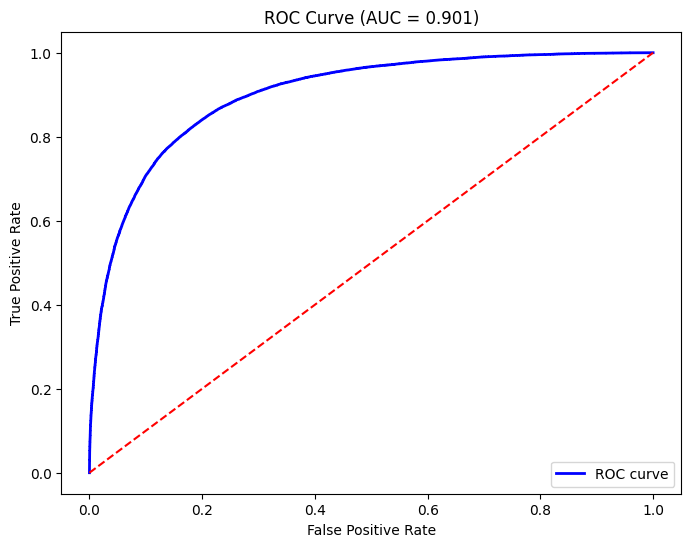

In [151]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {})'.format(round(roc_auc_score(y_test, y_prob), 3)))
plt.legend(loc='lower right')
plt.show()

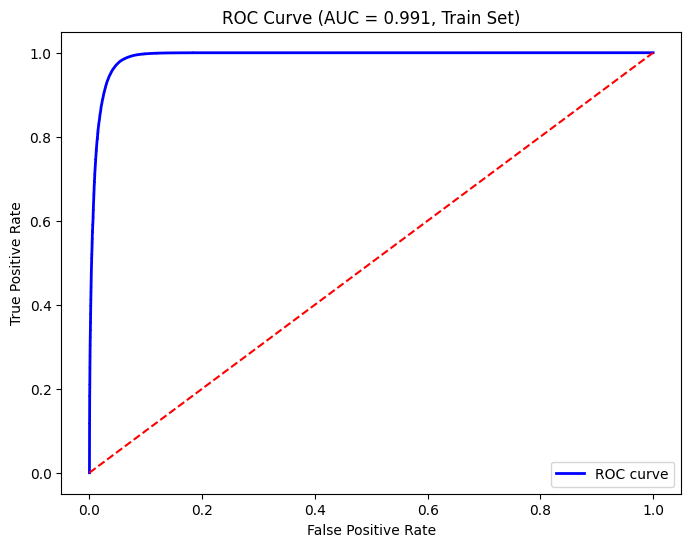

In [152]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {}, Train Set)'.format(round(roc_auc_score(y_train, y_prob_train), 3)))
plt.legend(loc='lower right')
plt.show()

In [153]:
# Test Set K-Fold Cross Validation
cv_results = cross_validate(model_tuned, 
                            X_test, y_test,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Accuracy:", round(cv_results["test_accuracy"].mean(), 2))
print("Precision:", round(cv_results["test_precision"].mean(), 2))
print("Recall:", round(cv_results["test_recall"].mean(), 2))
print("f1:", round(cv_results["test_f1"].mean(), 2))
print("roc_auc:", round(cv_results["test_roc_auc"].mean(), 2))

Accuracy: 0.77
Precision: 0.75
Recall: 0.79
f1: 0.77
roc_auc: 0.85


In [154]:
# Train Set K-Fold Cross Validation
cv_results = cross_validate(model_tuned, 
                            X_train, y_train,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

print("Accuracy:", round(cv_results["test_accuracy"].mean(), 2))
print("Precision:", round(cv_results["test_precision"].mean(), 2))
print("Recall:", round(cv_results["test_recall"].mean(), 2))
print("f1:", round(cv_results["test_f1"].mean(), 2))
print("roc_auc:", round(cv_results["test_roc_auc"].mean(), 2))

Accuracy: 0.81
Precision: 0.79
Recall: 0.84
f1: 0.81
roc_auc: 0.89


# Confusion Matrix

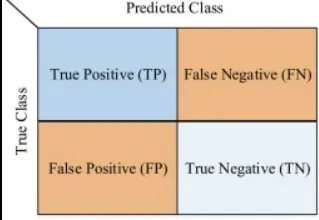](http://)

Confusion Matrix is used to evaluate the performance metrics of the classification models. In this matrix, there are actual values and predicted values.

Accuracy: It is the ratio of correct predictions. Accuracy is a performance evaluation metric that we focus on/consider in balanced datasets. The higher the accuracy value, the higher the model's success. Accuracy = (TP + TN) / (TP + TN + FP + FN)

Precision: It is the percentage of true positives among the instances predicted as positive. For example, if we are conducting a fraud analysis and we say that 5 people are fraudsters, but in reality, only 3 people are fraudsters. In this case, our Precision value is 3 / 5 = 0.6. When we mistakenly label non-fraudulent people as fraudsters, it leads to a Type 1 error. Precision = TP / (TP + FP)

Recall: It indicates how many of the instances of the positive class are correctly predicted. For example, if we are conducting a fraud analysis and we say that 5 people are fraudsters, but in reality, only 8 people are fraudsters. In this case, our Recall value is 5/8. When we mistakenly label fraudulent people as non-fraudulent, it leads to significant problems for the company, which is referred to as a Type 2 error. Recall = TP / (TP + FN)

F1 score: It is the harmonic mean of Precision and Recall values. Precision and Recall values are generally inversely proportional, so the harmonic mean of these two values is calculated, especially in "imbalanced" datasets, as a model performance metric. f1 = 2 * precision * recall / (precision + recall)

# Feature Importances

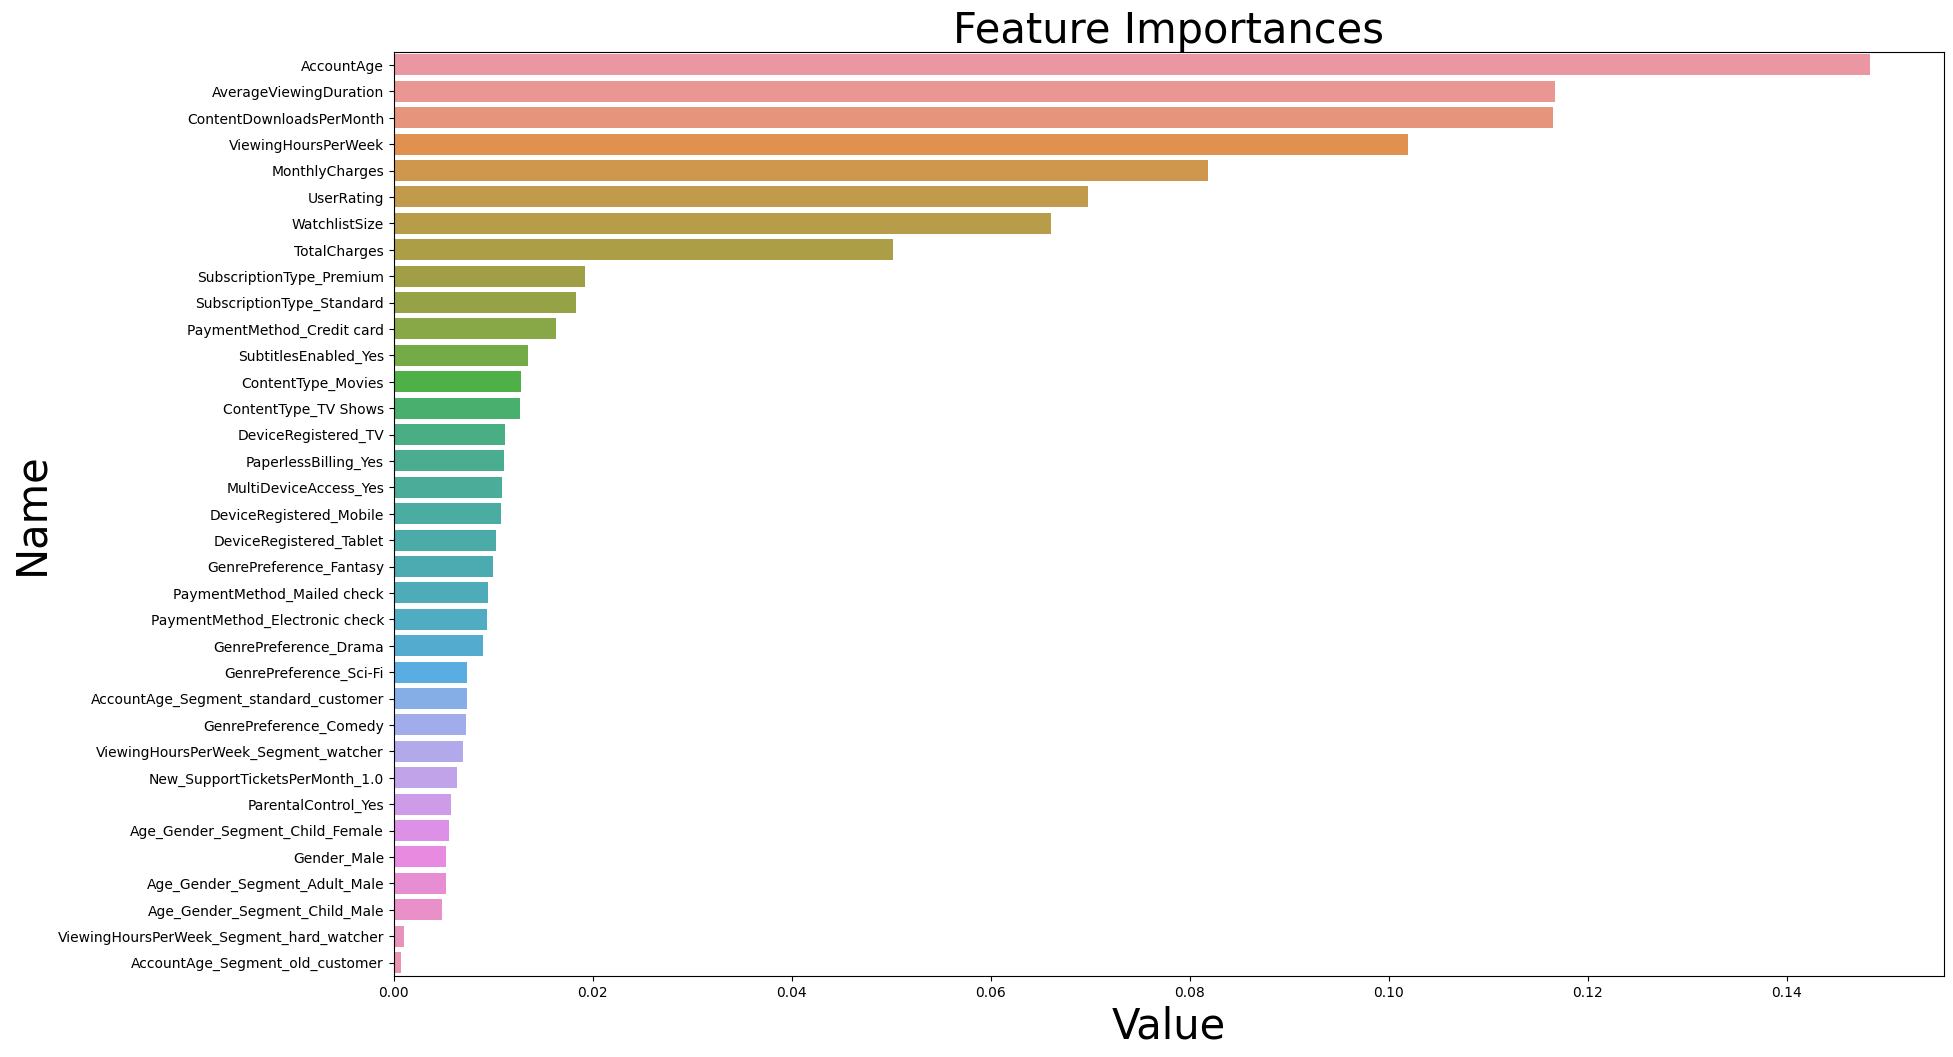

In [158]:
def plot_feature_improtances(model, feature, num=len(X)):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_,
                                "Name": feature.columns})
    plt.figure(figsize=(20, 12))
    sns.barplot(x="Value", y="Name", data=feature_imp.sort_values("Value", ascending=False)[0: num])
    plt.title("Feature Importances", fontsize=30)
    plt.xlabel("Value", fontsize=30)
    plt.ylabel("Name", fontsize=30)
    plt.show()

plot_feature_improtances(model_tuned, X_test)


# SMOTE DecisionTree

In [174]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.concat([X_train_resampled, pd.Series(y_train_resampled,
                                                         name='Churn')], axis=1)


X_resampled = resampled_data.drop('Churn', axis=1)
y_resampled = resampled_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.25,
                                                    random_state=42)

class_weights = {0: 1, 1: 3}  # Penalty Coefficients
cart_model = DecisionTreeClassifier(random_state=45, class_weight=class_weights).fit(X_train, y_train)

In [175]:
# Test Set
y_pred = cart_model.predict(X_test)
print(classification_report(y_test, y_pred))
y_prob = cart_model.predict_proba(X_test)[:, 1]
print("roc_auc-->", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     31838
           1       0.73      0.74      0.74     32154

    accuracy                           0.73     63992
   macro avg       0.73      0.73      0.73     63992
weighted avg       0.73      0.73      0.73     63992

roc_auc--> 0.7344464426359041


In [176]:
# Train Set
y_pred_train = cart_model.predict(X_train)
print(classification_report(y_train, y_pred_train))
y_prob_train = cart_model.predict_proba(X_train)[:, 1]
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     96145
           1       1.00      1.00      1.00     95829

    accuracy                           1.00    191974
   macro avg       1.00      1.00      1.00    191974
weighted avg       1.00      1.00      1.00    191974

roc_auc--> 1.0


# Model is in Overfitting!

In [177]:
print(cart_model.get_params())

{'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 3}, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 45, 'splitter': 'best'}


# Hyperparameter Optimization w RandomizedSearchCV

In [178]:
params = {"criterion": ["gini", "entropy"],
          "max_depth": range(2, 30),
          "splitter": ["best", "random"],
          "min_samples_split": range(2, 10),
          "min_samples_leaf": range(1, 5),
          "max_features": ["auto", "sqrt", "log2", 3, 5, 7]}

cart_random = RandomizedSearchCV(estimator=cart_model,
                               param_distributions=params,
                               cv=3,
                               random_state=42,
                               n_iter=100, n_jobs=-1)
cart_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 3},
                                                    random_state=45),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 30),
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         3, 5, 7],
                                        'min_samples_leaf': range(1, 5),
                                        'min_samples_split': range(2, 10),
                                        'splitter': ['best', 'random']},
                   random_state=42)

In [179]:
print("Best Parameters-->", cart_random.best_params_)
print("Best Score-->", cart_random.best_score_)

Best Parameters--> {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 7, 'max_depth': 22, 'criterion': 'gini'}
Best Score--> 0.7115807411977401


# MODEL TUNED

In [180]:
cart_tuned_model = cart_model.set_params(**cart_random.best_params_).fit(X_train, y_train)

In [181]:
# Test Set
y_pred = cart_tuned_model.predict(X_test)
print(classification_report(y_test, y_pred))
y_prob = cart_tuned_model.predict_proba(X_test)[:, 1]
print("roc_auc-->", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.77      0.63      0.70     31838
           1       0.69      0.81      0.75     32154

    accuracy                           0.73     63992
   macro avg       0.73      0.72      0.72     63992
weighted avg       0.73      0.73      0.72     63992

roc_auc--> 0.7512364808465047


In [183]:
# Train Set
y_pred_train = cart_tuned_model.predict(X_train)
print(classification_report(y_train, y_pred_train))
y_prob_train = cart_tuned_model.predict_proba(X_train)[:, 1]
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

              precision    recall  f1-score   support

           0       0.99      0.82      0.90     96145
           1       0.85      0.99      0.91     95829

    accuracy                           0.91    191974
   macro avg       0.92      0.91      0.91    191974
weighted avg       0.92      0.91      0.91    191974

roc_auc--> 0.9716244367428405


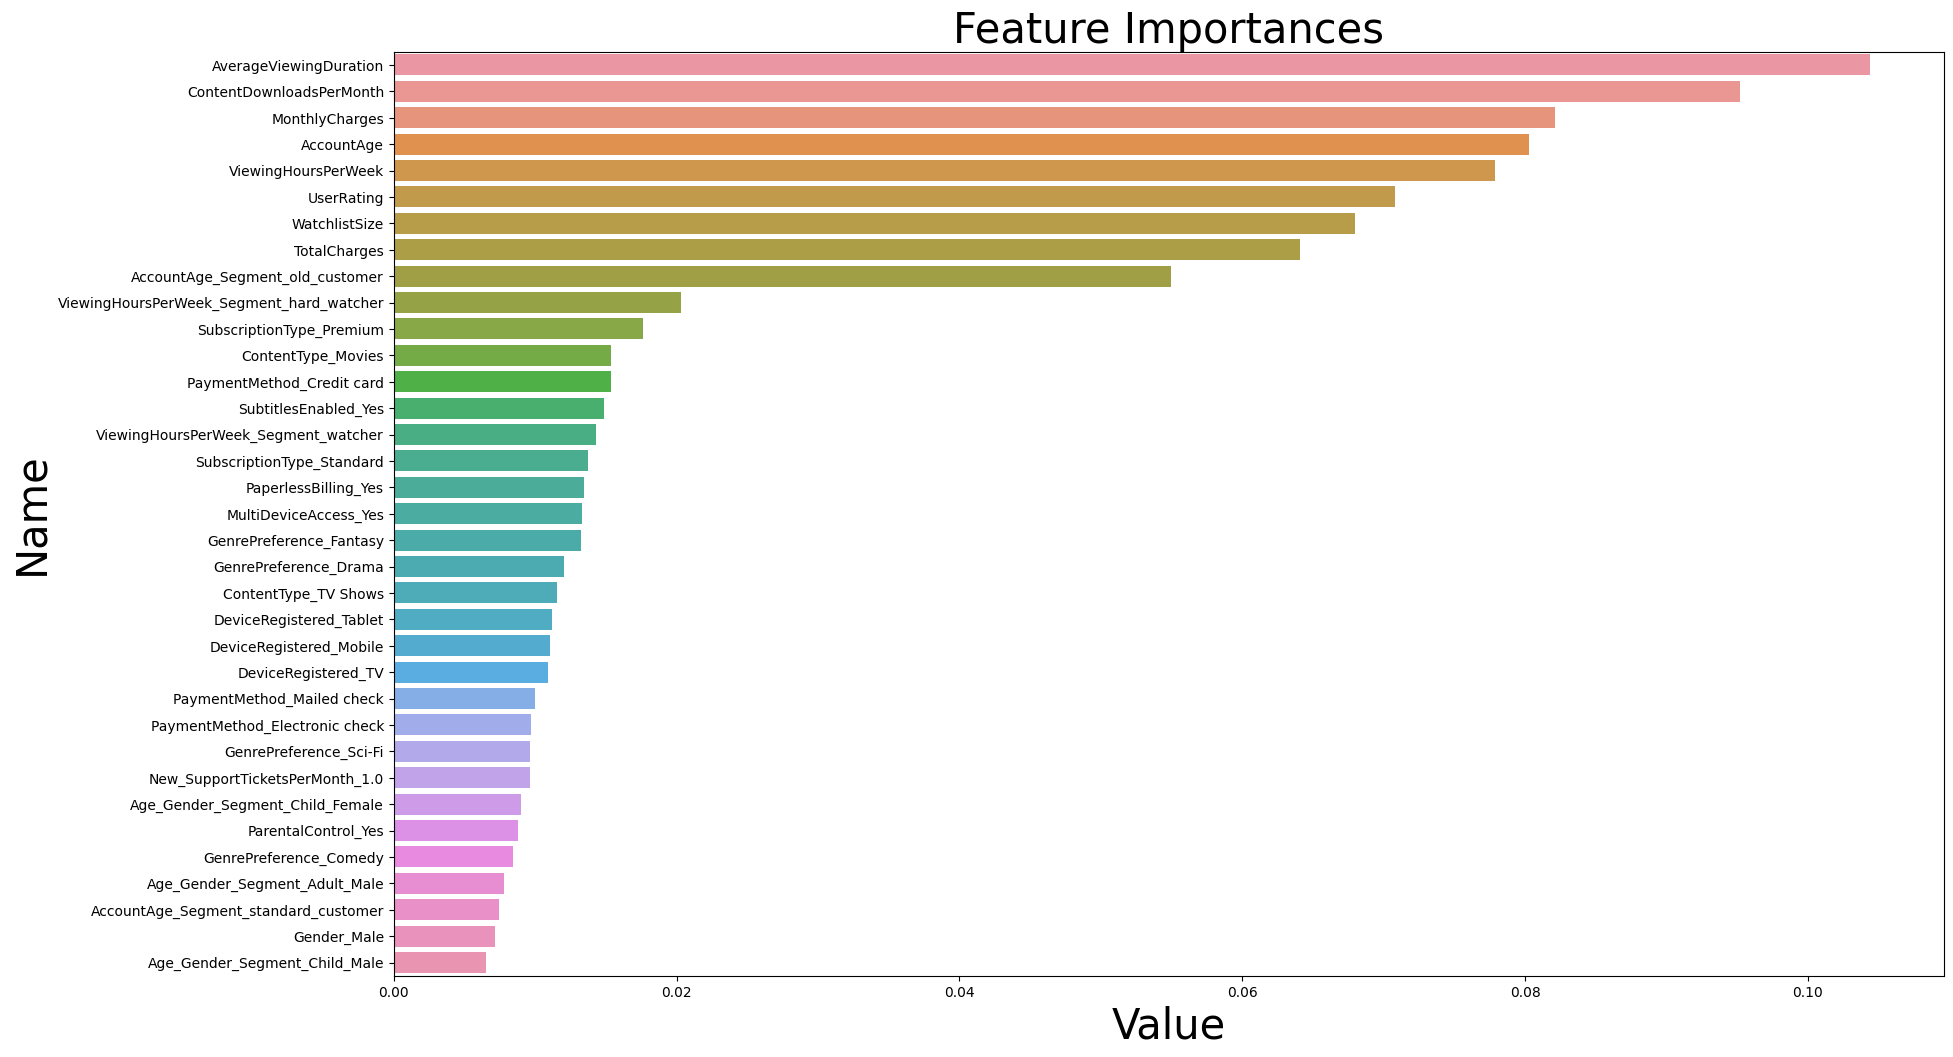

In [184]:
plot_feature_improtances(cart_tuned_model, X_test)

# BalancedBaggingClassifier

In [185]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import BalancedBaggingClassifier

bbc = BalancedBaggingClassifier(DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
balanced_accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81     31838
           1       0.82      0.78      0.80     32154

    accuracy                           0.80     63992
   macro avg       0.80      0.80      0.80     63992
weighted avg       0.80      0.80      0.80     63992



In [186]:
y_pred_train = bbc.predict(X_train)
print(balanced_accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

0.9922737528987564
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     96145
           1       1.00      0.99      0.99     95829

    accuracy                           0.99    191974
   macro avg       0.99      0.99      0.99    191974
weighted avg       0.99      0.99      0.99    191974



# SMOTE LightGBM Model After Feature Selection

Feature selection is the process of not including variables that will not affect the success of the model in machine learning. Thus, while the model's success remains the same, the model's performance will increase because we are building the model with fewer variables. In hyperparameter optimization, for example, the processing time will be shorter due to fewer variables.

In [56]:
df2 = df_.copy()
df2.head()

AccountAge  MonthlyCharges  TotalCharges SubscriptionType     PaymentMethod PaperlessBilling ContentType MultiDeviceAccess DeviceRegistered  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth GenrePreference  UserRating  SupportTicketsPerMonth  Gender  WatchlistSize ParentalControl SubtitlesEnabled  CustomerID  Churn
0          20       11.055215    221.104302          Premium      Mailed check               No        Both                No           Mobile            36.758104               63.531377                        10          Sci-Fi    2.176498                       4    Male              3              No               No  CB6SXPNVZA      0
1          57        5.175208    294.986882            Basic       Credit card              Yes      Movies                No           Tablet            32.450568               25.725595                        18          Action    3.478632                       8    Male             23              No              Yes  S7R2G87O09      0
2          73       12.106657    883.785952            Basic      Mailed check              Yes      Movies                No         Computer             7.395160               57.364061                        23         Fantasy    4.238824                       6    Male              1             Yes              Yes  EASDC20BDT      0
3          32        7.263743    232.439774            Basic  Electronic check               No    TV Shows                No           Tablet            27.960389              131.537507                        30           Drama    4.276013                       2    Male             24             Yes              Yes  NPF69NT69N      0
4          57       16.953078    966.325422          Premium  Electronic check              Yes    TV Shows                No               TV            20.083397               45.356653                        20          Comedy    3.616170                       4  Female              0              No               No  4LGYPK7VOL      0

In [57]:
df2.drop(["PaymentMethod", "PaperlessBilling", "GenrePreference", "Gender", "ContentType",
          "SupportTicketsPerMonth", "ParentalControl", "DeviceRegistered", "CustomerID"], axis=1, inplace=True)
df2.head()

AccountAge  MonthlyCharges  TotalCharges SubscriptionType MultiDeviceAccess  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize SubtitlesEnabled  Churn
0          20       11.055215    221.104302          Premium                No            36.758104               63.531377                        10    2.176498              3               No      0
1          57        5.175208    294.986882            Basic                No            32.450568               25.725595                        18    3.478632             23              Yes      0
2          73       12.106657    883.785952            Basic                No             7.395160               57.364061                        23    4.238824              1              Yes      0
3          32        7.263743    232.439774            Basic                No            27.960389              131.537507                        30    4.276013             24              Yes      0
4          57       16.953078    966.325422          Premium                No            20.083397               45.356653                        20    3.616170              0               No      0

In [58]:
cat_var, cat_but_car, num_var = grab_variable(df2)

Observation: 243787
Number of Variables: 12
Number of Categoric Variables: 4
Number of Num but Cat Variables: 1
Number of Cat but Cardinal Variables: 0
Number of Numeric Variables: 8


In [60]:
cat_var.remove("Churn")
df2 = pd.get_dummies(data=df2, columns=cat_var, dtype="int64", drop_first=True)
df2.head()

AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize  Churn  SubscriptionType_Premium  SubscriptionType_Standard  MultiDeviceAccess_Yes  SubtitlesEnabled_Yes
0          20       11.055215    221.104302            36.758104               63.531377                        10    2.176498              3      0                         1                          0                      0                     0
1          57        5.175208    294.986882            32.450568               25.725595                        18    3.478632             23      0                         0                          0                      0                     1
2          73       12.106657    883.785952             7.395160               57.364061                        23    4.238824              1      0                         0                          0                      0                     1
3          32        7.263743    232.439774            27.960389              131.537507                        30    4.276013             24      0                         0                          0                      0                     1
4          57       16.953078    966.325422            20.083397               45.356653                        20    3.616170              0      0                         1                          0                      0                     0

In [62]:
standardization(df2, num_var)
df2.head()

AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize  Churn  SubscriptionType_Premium  SubscriptionType_Standard  MultiDeviceAccess_Yes  SubtitlesEnabled_Yes
0   -1.169131       -0.331703     -1.012550             1.445777               -0.568906                 -1.005712   -0.715179      -1.253786      0                         1                          0                      0                     0
1   -0.089945       -1.690423     -0.871303             1.062671               -1.317459                 -0.450971    0.411960       1.526687      0                         0                          0                      0                     1
2    0.376731       -0.088741      0.254353            -1.165718               -0.691019                 -0.104258    1.069988      -1.531833      0                         0                          0                      0                     1
3   -0.819125       -1.207816     -0.990879             0.663322                0.777613                  0.381141    1.102179       1.665711      0                         0                          0                      0                     1
4   -0.089945        1.031143      0.412150            -0.037246               -0.928765                 -0.312285    0.531014      -1.670857      0                         1                          0                      0                     0

In [63]:
X = df2.drop("Churn", axis=1)
y = df2["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

resampled_data = pd.concat([X_train_resampled, pd.Series(y_train_resampled, name='Churn')], axis=1)

X_resampled = resampled_data.drop('Churn', axis=1)
y_resampled = resampled_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.20,
                                                    random_state=42)

In [79]:
smote_lgbm = LGBMClassifier(random_state=42, verbosity=-1)
smote_lgbm.fit(X_train, y_train)

LGBMClassifier(random_state=42, verbosity=-1)

In [80]:
# Test Set
y_pred = smote_lgbm.predict(X_test)
y_prob = smote_lgbm.predict_proba(X_test)[:, 1]
print("Classification Report\n", classification_report(y_test, y_pred))
print("roc_auc-->", roc_auc_score(y_test, y_prob))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.96      0.89     32030
           1       0.96      0.79      0.87     31825

    accuracy                           0.88     63855
   macro avg       0.89      0.88      0.88     63855
weighted avg       0.89      0.88      0.88     63855

roc_auc--> 0.9371255708574467


In [81]:
# Train Set
y_pred_train = smote_lgbm.predict(X_train)
y_prob_train = smote_lgbm.predict_proba(X_train)[:, 1]
print("Classification Report\n", classification_report(y_train, y_pred_train))
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

Classification Report
               precision    recall  f1-score   support

           0       0.82      0.97      0.89    127607
           1       0.96      0.79      0.87    127812

    accuracy                           0.88    255419
   macro avg       0.89      0.88      0.88    255419
weighted avg       0.89      0.88      0.88    255419

roc_auc--> 0.9387528204306888


# Hyperparameter Optimization

In [82]:
smote_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbosity': -1}

In [85]:
params = {"max_depth": range(-1, 5),
          "n_estimators": [100, 200, 300],
          "subsample": [0.6, 0.8, 1.0]}

smote_lgbm_cv = GridSearchCV(estimator=smote_lgbm,  # Model
                            param_grid=params,      # Parameters
                            cv=3,                   # Cross Validate Value
                            scoring="f1",           # Validation Score 
                            n_jobs=-1).fit(X_train, y_train) 


In [86]:
print("Best Params-->", smote_lgbm_cv.best_params_)
print("Best Score-->", smote_lgbm_cv.best_score_)

Best Params--> {'max_depth': -1, 'n_estimators': 300, 'subsample': 0.6}
Best Score--> 0.8738630542942675


In [87]:
model_tuned = smote_lgbm.set_params(**smote_lgbm_cv.best_params_).fit(X_train, y_train)

In [88]:
# Test Set
y_pred = model_tuned.predict(X_test)
y_prob = model_tuned.predict_proba(X_test)[:, 1]
print("Classification Report\n", classification_report(y_test, y_pred))
print("roc_auc-->", roc_auc_score(y_test, y_prob))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.97      0.90     32030
           1       0.97      0.80      0.87     31825

    accuracy                           0.89     63855
   macro avg       0.90      0.89      0.89     63855
weighted avg       0.90      0.89      0.89     63855

roc_auc--> 0.9395983125599798


In [89]:
# Train Set
y_pred_train = model_tuned.predict(X_train)
y_prob_train = model_tuned.predict_proba(X_train)[:, 1]
print("Classification Report\n", classification_report(y_train, y_pred_train))
print("roc_auc-->", roc_auc_score(y_train, y_prob_train))

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.98      0.90    127607
           1       0.98      0.80      0.88    127812

    accuracy                           0.89    255419
   macro avg       0.90      0.89      0.89    255419
weighted avg       0.90      0.89      0.89    255419

roc_auc--> 0.9479497813119485


In [152]:
# Prediction:
random_customer = X.sample(1)
random_customer

AccountAge  MonthlyCharges  TotalCharges  ViewingHoursPerWeek  AverageViewingDuration  ContentDownloadsPerMonth  UserRating  WatchlistSize  SubscriptionType_Premium  SubscriptionType_Standard  MultiDeviceAccess_Yes  SubtitlesEnabled_Yes
107836   -1.256633       -1.236094     -1.203157            -1.291357               -1.699002                 -0.797684   -0.318996       1.665711                         0                          0                      1                     0

In [153]:
df[df.index == random_customer.index[0]]["Churn"]

107836    1
Name: Churn, dtype: int64

In [154]:
print("Prediction Outcome for Random Customer:\t", model_tuned.predict(random_customer))

Prediction Outcome for Random Patient:	 [1]


Train Score Mean--> [0.74163382 0.74625703 0.75437227 0.7695029  0.7950894  0.80425379
 0.8068566  0.80838305 0.8111083 ]
Test Score Mean--> [0.7390679  0.73844189 0.73711705 0.73476147 0.73159971 0.73141453
 0.73172336 0.73160186 0.7317342 ]


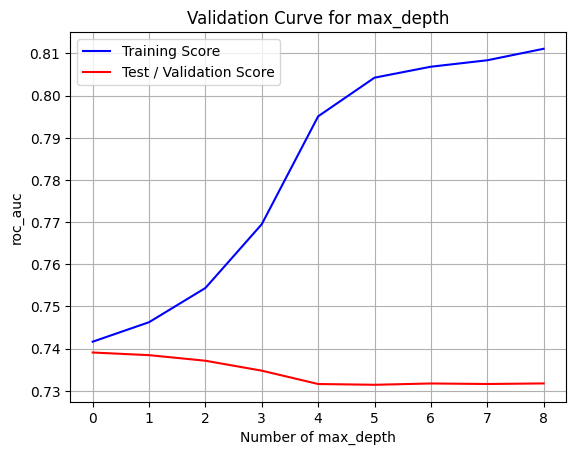

In [156]:
# 7. Analyzing model complexity with Learning Curves
from sklearn.model_selection import validation_curve

train_score, test_score = validation_curve(model_tuned,
                                           X, y,
                                           cv=2,
                                           param_name="max_depth",
                                           param_range=range(1, 10),
                                           scoring="roc_auc")

mean_train_score = np.mean(train_score, axis=1)
mean_test_score = np.mean(test_score, axis=1)
print("Train Score Mean-->", mean_train_score)
print("Test Score Mean-->", mean_test_score)

plt.plot(mean_train_score,
         label="Training Score", color="blue")

plt.plot(mean_test_score,
         label="Test / Validation Score", color="red")

plt.title("Validation Curve for max_depth")
plt.xlabel("Number of max_depth")
plt.ylabel("roc_auc")
plt.grid()
plt.legend(loc="best")
plt.show()